In [166]:
import polars as pl
import numpy as np
from typing import List

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def lag_exprs(col: str, lags: List[int]) -> List[pl.Expr]:
    return [
        pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")
        for lag in lags
    ]


def cross_comb_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) + (pl.col(b) + 1e-8)).alias(f"{a}_comb_{b}")

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        )
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lag: int,
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            diff_expr(col),
            second_order_diff_expr(col),
            momentum_ratio_expr(col, lag),
            rolling_volatility_expr(col, window),
        ])
        # single_exprs.extend(lag_exprs(col, [10, 20, 50, 100, 200]))

    return single_exprs

def batch_apply_multi_exprs(
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_comb_expr(a, b),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lag: int,
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
   
    single_exprs = batch_apply_single_exprs(window, lag, base_cols)
    multi_exprs = batch_apply_multi_exprs(base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(single_exprs)



In [168]:
import polars as pl
import numpy as np
from typing import List
from tqdm import tqdm

def split_df_by_week(
        origin_input_df: pl.DataFrame,
        ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    unique_weeks = origin_input_df.select("week_start").unique().sort("week_start")

    weekly_dfs = [
        origin_input_df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs


def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window, min_samples=1)
        .tanh()
        .rolling_mean(window, min_samples=1)
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and col.startswith("z_") 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [637]:
origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.001_rolling200.csv")
print(origin_df)
origin_df = batch_apply_transforms(origin_df, 200, 1)


shape: (27_214, 115)
┌──────────────────┬──────────┬────────────┬─────────────┬───┬─────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ timestamp        ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_momentum_t ┆ z_factor_order_sen ┆ z_factor_oi_moment ┆ z_factor_oi_moment │
│ ---              ┆ ---      ┆ ---        ┆ ---         ┆   ┆ rend_confir…        ┆ timent_diver…      ┆ um_punch           ┆ um_long_term…      │
│ i64              ┆ f64      ┆ f64        ┆ f64         ┆   ┆ ---                 ┆ ---                ┆ ---                ┆ ---                │
│                  ┆          ┆            ┆             ┆   ┆ f64                 ┆ f64                ┆ f64                ┆ f64                │
╞══════════════════╪══════════╪════════════╪═════════════╪═══╪═════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ 1744003134974000 ┆ 77116.4  ┆ 41.241     ┆ 18.209      ┆ … ┆ 0.759049            ┆ -0.668

In [667]:
avg_steps_pct = 400

origin_df = origin_df.with_columns([
    future_return_expr("px", avg_steps_pct),
])
print(origin_df)

origin_df = rolling_mean_tanh_normalize(origin_df, 200)
origin_df = clean_df_drop_nulls(origin_df)

weekly_dataframes = split_df_by_week(origin_df)
print("num weekly dfs: ", len(weekly_dataframes))

shape: (24_995, 1_135)
┌──────────────────┬──────────┬────────────┬─────────────┬───┬──────────────────────┬──────────────────────┬──────────────────┬───────────────────┐
│ timestamp        ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_oi_momentum ┆ z_factor_oi_momentum ┆ future_return_20 ┆ future_return_400 │
│ ---              ┆ ---      ┆ ---        ┆ ---         ┆   ┆ _long_term…          ┆ _long_term…          ┆ ---              ┆ ---               │
│ i64              ┆ f64      ┆ f64        ┆ f64         ┆   ┆ ---                  ┆ ---                  ┆ f64              ┆ f64               │
│                  ┆          ┆            ┆             ┆   ┆ f64                  ┆ f64                  ┆                  ┆                   │
╞══════════════════╪══════════╪════════════╪═════════════╪═══╪══════════════════════╪══════════════════════╪══════════════════╪═══════════════════╡
│ 1744009518143000 ┆ 74635.7  ┆ 349.294    ┆ 155.914     ┆ … ┆ 1.0                  ┆ 0.8

In [669]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder
import torch

import numpy as np
import matplotlib.pyplot as plt

In [671]:
import matplotlib.pyplot as plt
import numpy as np

def plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px, n=700):
    # 截取最后 n 行
    y_test_slice = y_test[-n:]
    y_test_binary_slice = y_test_binary[-n:]
    y_pred_prob_slice = y_pred_prob[-n:]
    px_slice = px[-n:]

    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 原始收益
    ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    ax1.set_ylabel("Original Future Returns", color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # GMM 标签
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 模型预测概率
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="MODEL Predicted Probability", color='tab:green', alpha=0.4)
    ax3.set_ylabel("MODEL Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # 加价格线 (第4轴)
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))  # 再右移一层
    ax4.plot(time_index, px_slice, label="Price (px)", color='tab:red', linestyle='--', alpha=0.6)
    ax4.set_ylabel("Price (px)", color='tab:red')
    ax4.tick_params(axis='y', labelcolor='tab:red')

    # x轴
    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Returns, Labels, Prediction & Price (Last {n} Rows)")

    # 图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()


In [673]:
from sklearn.mixture import GaussianMixture
import numpy as np

def gmm_label_binarize(y_train, y_val=None, y_test=None, verbose=True, random_state=42):
    """
    用 GMM 对收益率进行聚类，然后按均值高低映射为上涨(1)/下跌(0)标签。
    
    参数:
        y_train, y_val, y_test: Series 或 ndarray
        verbose: 是否打印详细映射信息
    返回:
        y_train_binary, y_val_binary, y_test_binary, gmm_model
    """
    y_train_np = np.asarray(y_train).reshape(-1, 1)
    y_val_np = np.asarray(y_val).reshape(-1, 1) if y_val is not None else None
    y_test_np = np.asarray(y_test).reshape(-1, 1) if y_test is not None else None

    # GMM 拟合
    gmm = GaussianMixture(n_components=2, random_state=random_state)
    gmm.fit(y_train_np)

    means = gmm.means_.flatten()
    upward_label = np.argmax(means)
    downward_label = np.argmin(means)

    if verbose:
        print(f"GMM 分量均值: {means}")
        print(f"上涨标签: {upward_label}, 下跌标签: {downward_label}")

    # 标签转换函数
    def transform_labels(y_np):
        raw = gmm.predict(y_np)
        binary = (raw == upward_label).astype(int)
        return binary, raw

    y_train_binary, train_raw = transform_labels(y_train_np)
    y_val_binary, val_raw = transform_labels(y_val_np) if y_val_np is not None else (None, None)
    y_test_binary, test_raw = transform_labels(y_test_np) if y_test_np is not None else (None, None)

    if verbose:
        print("\n--- GMM 原始标签 => 最终二元标签映射 ---")
        for label in [0, 1]:
            print(f"GMM 内部标签 {label} (均值: {means[label]:.6f}) => 二元标签: {1 if label == upward_label else 0}")

        print("\n--- 示例标签 ---")
        print("训练集原始收益:", y_train_np[:10].flatten())
        print("训练集GMM标签:", train_raw[:10])
        print("训练集二元标签:", y_train_binary[:10])

        if y_test_binary is not None:
            print("\n测试集原始收益:", y_test_np[:10].flatten())
            print("测试集GMM标签:", test_raw[:10])
            print("测试集二元标签:", y_test_binary[:10])

    return y_train_binary, y_val_binary, y_test_binary, gmm


In [675]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def evaluate_with_confidence(
    y_true,
    y_pred_proba,                      
    model_name="Model",                    
    lower_thresh=0.15,                  
    upper_thresh=0.85,       
    print_report=True,
):

    # ===== 基础评估 (全样本) =====
    base_pred = (y_pred_proba >= 0.5).astype(int)
    base_acc = accuracy_score(y_true, base_pred)
    
    # ===== 置信预测评估 =====
    # 生成交易信号 (-1: 不交易, 0: 做空, 1: 做多)
    signals = np.full_like(y_pred_proba, fill_value=-1, dtype=int)
    signals[y_pred_proba <= lower_thresh] = 0
    signals[y_pred_proba >= upper_thresh] = 1
    
    # 计算置信预测指标
    mask = signals != -1
    conf_acc = accuracy_score(y_true[mask], signals[mask]) if any(mask) else np.nan
    trading_rate = mask.mean()
    
    # ===== 结果组织 =====
    eval_dict = {
        'model': model_name,
        'thresholds': f"{lower_thresh}-{upper_thresh}",
        'base_accuracy': base_acc,
        'confident_accuracy': conf_acc,
        'trading_rate': trading_rate,
        'conf_matrix': confusion_matrix(y_true[mask], signals[mask]) if any(mask) else None,
        'class_report': classification_report(y_true[mask], signals[mask], output_dict=True) if any(mask) else None,
        'y_test_binary': y_true, 
        'y_pred_proba': y_pred_proba, 
        'signal': signals,
    }
    
    # ===== 打印输出 =====
    if print_report:
        print(f"\n=== {model_name} 评估结果 ===")
        print(f"📊 全样本准确率: {base_acc:.4f}")
        print(f"✅ 自信预测准确率: {conf_acc:.4f} (阈值 {lower_thresh}-{upper_thresh})")
        print(f"📈 出手率: {trading_rate:.2%}")
        
        if any(mask):
            print("\n🧮 自信预测混淆矩阵:")
            print(eval_dict['conf_matrix'])
            
            print("\n📝 分类报告:")
            print(classification_report(y_true[mask], signals[mask]))
        else:
            print("⚠️ 无自信预测样本!")
    
    return eval_dict


In [677]:
def evaluate_and_plot(model, name, X_val, y_val, X_test, y_test, y_val_bin, y_test_bin, px_val, px_test):
    val_pred = model.predict_proba(X_val)[:, 1]
    test_pred = model.predict_proba(X_test)[:, 1]
    
    val_eval = evaluate_with_confidence(
        y_true=y_val_bin,
        y_pred_proba=val_pred,
        model_name=f"{name} (Val)",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_val, y_val_bin, val_pred, px_val, n=2000)

    test_eval = evaluate_with_confidence(
        y_true=y_test_bin,
        y_pred_proba=test_pred,
        model_name=f"{name} (Test)",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_test, y_test_bin, test_pred, px_test, n=2000)

    return {'val': val_eval, 'test': test_eval}


Fold 0: Train 0~3, Val 4, Test 5
Train: 2025-04-07 07:05:18.143000 to 2025-05-04 23:55:19.066000
Val: 2025-05-05 00:01:39.539000 to 2025-05-11 23:57:01.156000
Test: 2025-05-12 00:05:11.740000 to 2025-05-18 23:59:34.191000
GMM 分量均值: [-0.00599639  0.01884874]
上涨标签: 1, 下跌标签: 0

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: -0.005996) => 二元标签: 0
GMM 内部标签 1 (均值: 0.018849) => 二元标签: 1

--- 示例标签 ---
训练集原始收益: [0.03048541 0.03050981 0.03049327 0.03259001 0.03260725 0.03052109
 0.02831653 0.02625501 0.02623348 0.02412875]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [1 1 1 1 1 1 1 1 1 1]

测试集原始收益: [-0.01376662 -0.01380403 -0.01385309 -0.01382959 -0.01383579 -0.01382126
 -0.01584105 -0.01583028 -0.01583917 -0.01583188]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]

=== lgb_model 评估结果 ===
📊 全样本准确率: 0.3498
✅ 自信预测准确率: 0.4223 (阈值 0.15-0.85)
📈 出手率: 62.56%

🧮 自信预测混淆矩阵:
[[296  22]
 [785 294]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.27      0.93    

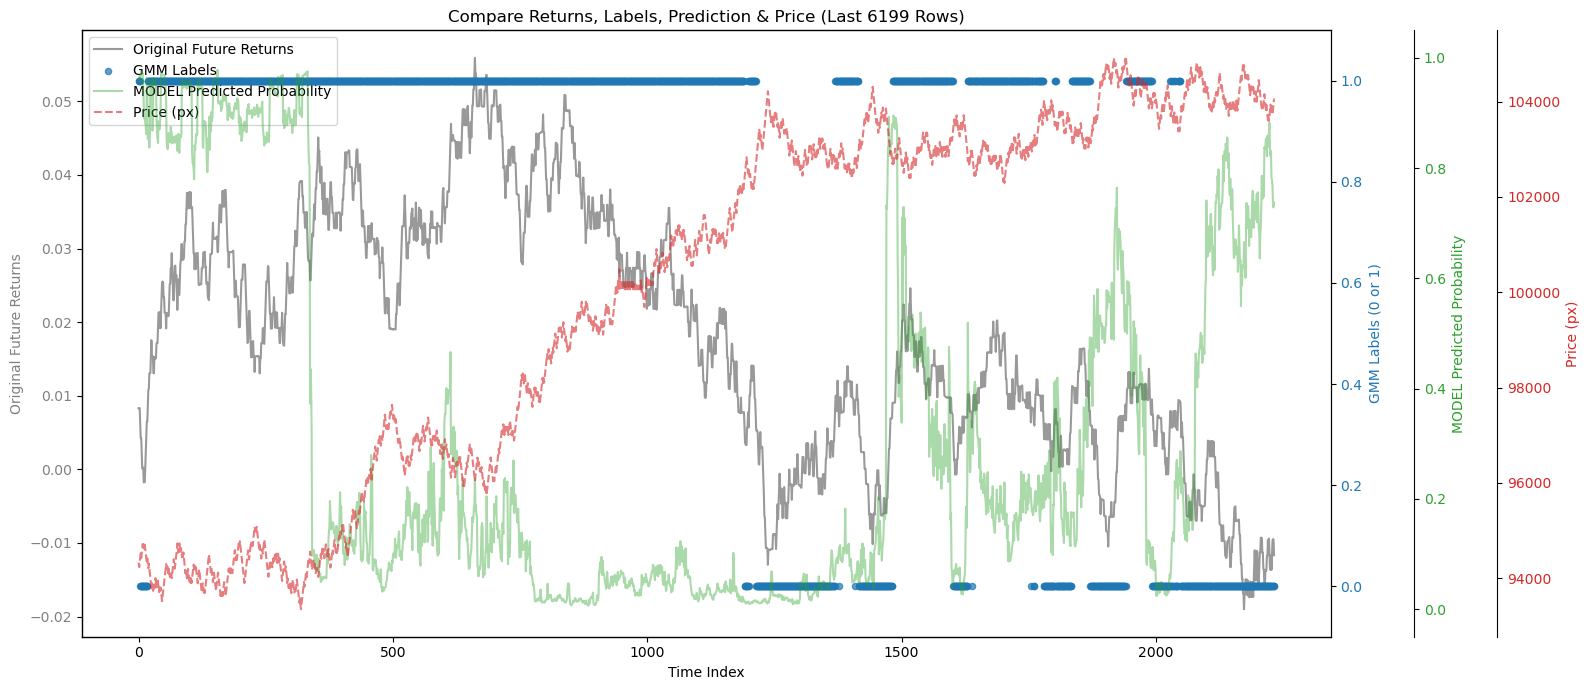


=== lgb_model 评估结果 ===
📊 全样本准确率: 0.4467
✅ 自信预测准确率: 0.4504 (阈值 0.15-0.85)
📈 出手率: 23.05%

🧮 自信预测混淆矩阵:
[[164  81]
 [185  54]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.47      0.67      0.55       245
           1       0.40      0.23      0.29       239

    accuracy                           0.45       484
   macro avg       0.43      0.45      0.42       484
weighted avg       0.44      0.45      0.42       484



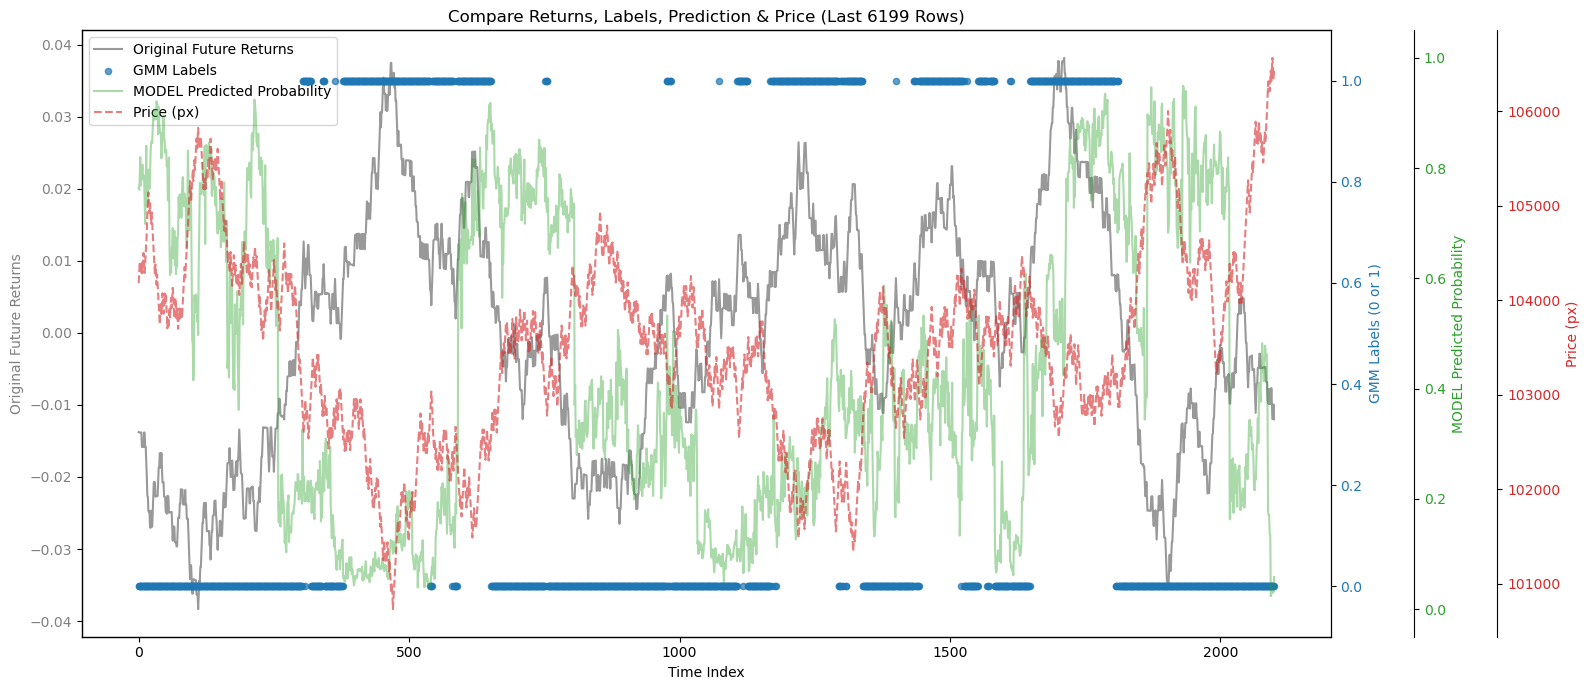


=== xgb_model 评估结果 ===
📊 全样本准确率: 0.4505
✅ 自信预测准确率: 0.3821 (阈值 0.15-0.85)
📈 出手率: 63.99%

🧮 自信预测混淆矩阵:
[[346  15]
 [868 200]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.29      0.96      0.44       361
           1       0.93      0.19      0.31      1068

    accuracy                           0.38      1429
   macro avg       0.61      0.57      0.38      1429
weighted avg       0.77      0.38      0.34      1429



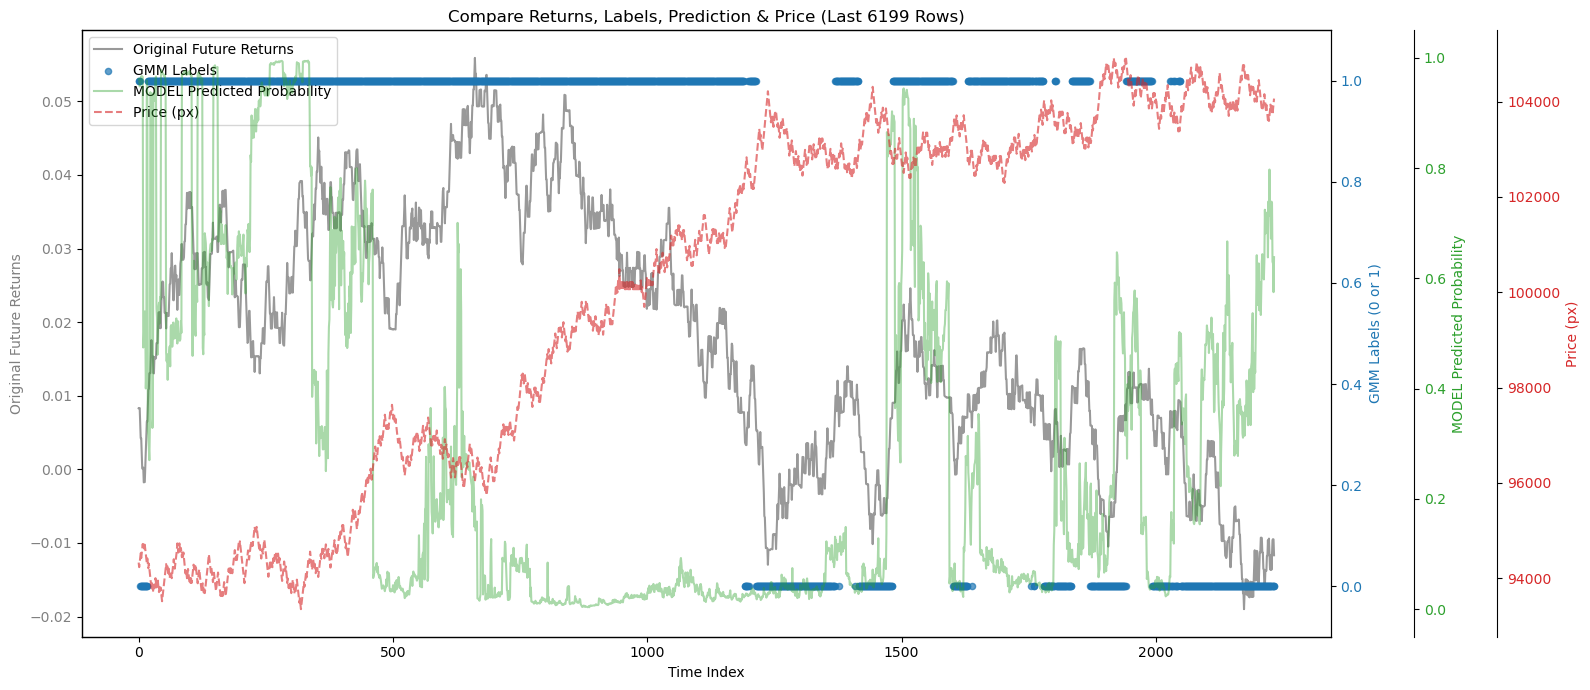


=== xgb_model 评估结果 ===
📊 全样本准确率: 0.4005
✅ 自信预测准确率: 0.3945 (阈值 0.15-0.85)
📈 出手率: 60.95%

🧮 自信预测混淆矩阵:
[[416 370]
 [405  89]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.51      0.53      0.52       786
           1       0.19      0.18      0.19       494

    accuracy                           0.39      1280
   macro avg       0.35      0.35      0.35      1280
weighted avg       0.39      0.39      0.39      1280



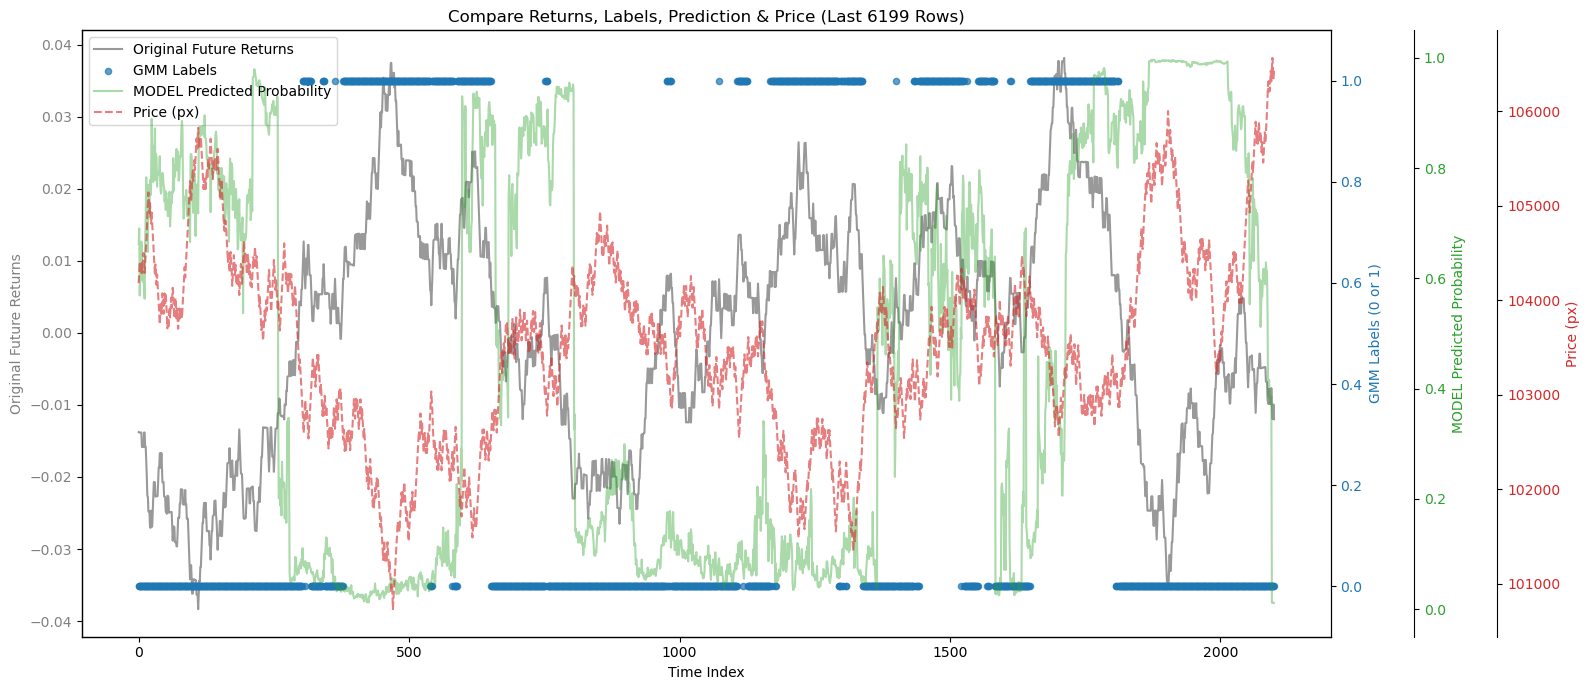

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85673 | val_0_accuracy: 0.52575 |  0:00:01s
epoch 1  | loss: 0.66202 | val_0_accuracy: 0.43395 |  0:00:02s
epoch 2  | loss: 0.63909 | val_0_accuracy: 0.45007 |  0:00:03s
epoch 3  | loss: 0.60725 | val_0_accuracy: 0.49664 |  0:00:05s
epoch 4  | loss: 0.55236 | val_0_accuracy: 0.31214 |  0:00:06s
epoch 5  | loss: 0.48881 | val_0_accuracy: 0.34169 |  0:00:07s
epoch 6  | loss: 0.44803 | val_0_accuracy: 0.35513 |  0:00:08s
epoch 7  | loss: 0.43113 | val_0_accuracy: 0.28437 |  0:00:10s
epoch 8  | loss: 0.35442 | val_0_accuracy: 0.39409 |  0:00:11s
epoch 9  | loss: 0.29775 | val_0_accuracy: 0.50381 |  0:00:12s
epoch 10 | loss: 0.27443 | val_0_accuracy: 0.4129  |  0:00:13s
epoch 11 | loss: 0.23176 | val_0_accuracy: 0.49127 |  0:00:15s
epoch 12 | loss: 0.22083 | val_0_accuracy: 0.4953  |  0:00:16s
epoch 13 | loss: 0.2197  | val_0_accuracy: 0.52978 |  0:00:17s
epoch 14 | loss: 0.20743 | val_0_accuracy: 0.55038 |  0:00:19s
epoch 15 | loss: 0.21286 | val_0_accuracy: 0.5159  |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.5647
✅ 自信预测准确率: 0.5713 (阈值 0.15-0.85)
📈 出手率: 65.61%

🧮 自信预测混淆矩阵:
[[303  78]
 [550 534]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.36      0.80      0.49       381
           1       0.87      0.49      0.63      1084

    accuracy                           0.57      1465
   macro avg       0.61      0.64      0.56      1465
weighted avg       0.74      0.57      0.59      1465



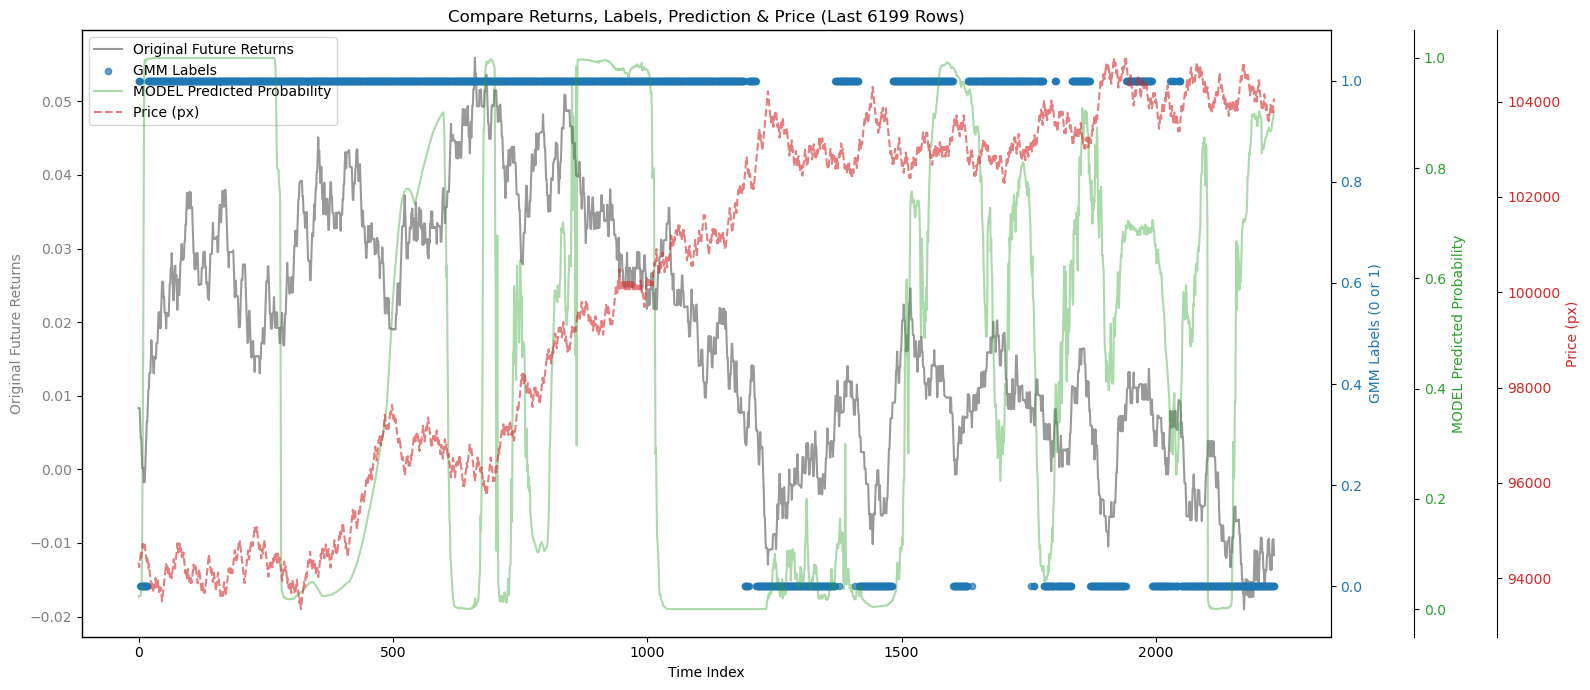


=== tabnet 评估结果 ===
📊 全样本准确率: 0.5595
✅ 自信预测准确率: 0.5824 (阈值 0.15-0.85)
📈 出手率: 74.81%

🧮 自信预测混淆矩阵:
[[587 484]
 [172 328]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.77      0.55      0.64      1071
           1       0.40      0.66      0.50       500

    accuracy                           0.58      1571
   macro avg       0.59      0.60      0.57      1571
weighted avg       0.66      0.58      0.60      1571



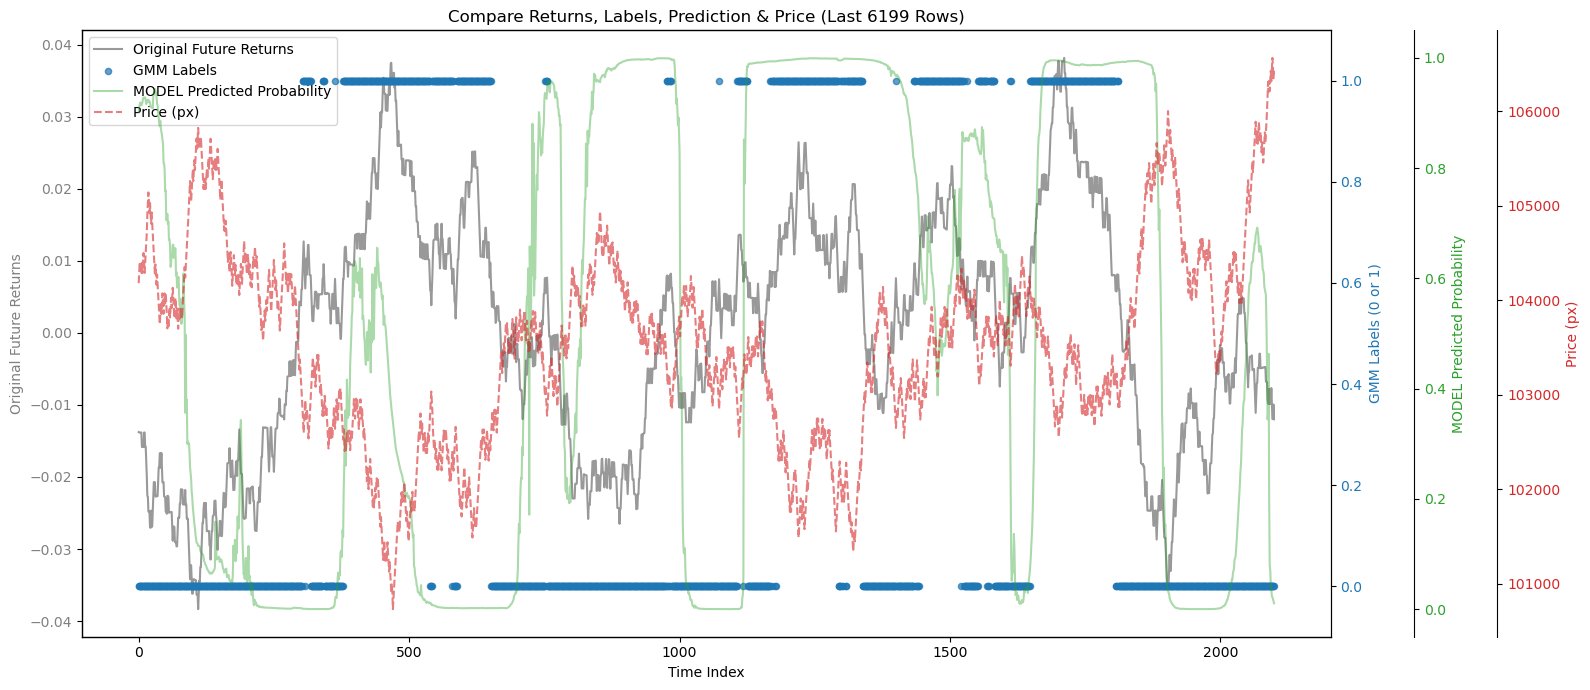

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85673 | val_0_accuracy: 0.52575 |  0:00:01s
epoch 1  | loss: 0.66202 | val_0_accuracy: 0.43395 |  0:00:02s
epoch 2  | loss: 0.63909 | val_0_accuracy: 0.45007 |  0:00:04s
epoch 3  | loss: 0.60725 | val_0_accuracy: 0.49664 |  0:00:05s
epoch 4  | loss: 0.55236 | val_0_accuracy: 0.31214 |  0:00:06s
epoch 5  | loss: 0.48881 | val_0_accuracy: 0.34169 |  0:00:08s
epoch 6  | loss: 0.44803 | val_0_accuracy: 0.35513 |  0:00:09s
epoch 7  | loss: 0.43113 | val_0_accuracy: 0.28437 |  0:00:10s
epoch 8  | loss: 0.35442 | val_0_accuracy: 0.39409 |  0:00:11s
epoch 9  | loss: 0.29775 | val_0_accuracy: 0.50381 |  0:00:13s
epoch 10 | loss: 0.27443 | val_0_accuracy: 0.4129  |  0:00:14s
epoch 11 | loss: 0.23176 | val_0_accuracy: 0.49127 |  0:00:15s
epoch 12 | loss: 0.22083 | val_0_accuracy: 0.4953  |  0:00:17s
epoch 13 | loss: 0.2197  | val_0_accuracy: 0.52978 |  0:00:18s
epoch 14 | loss: 0.20743 | val_0_accuracy: 0.55038 |  0:00:19s
epoch 15 | loss: 0.21286 | val_0_accuracy: 0.5159  |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5647
✅ 自信预测准确率: 0.5713 (阈值 0.15-0.85)
📈 出手率: 65.61%

🧮 自信预测混淆矩阵:
[[303  78]
 [550 534]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.36      0.80      0.49       381
           1       0.87      0.49      0.63      1084

    accuracy                           0.57      1465
   macro avg       0.61      0.64      0.56      1465
weighted avg       0.74      0.57      0.59      1465



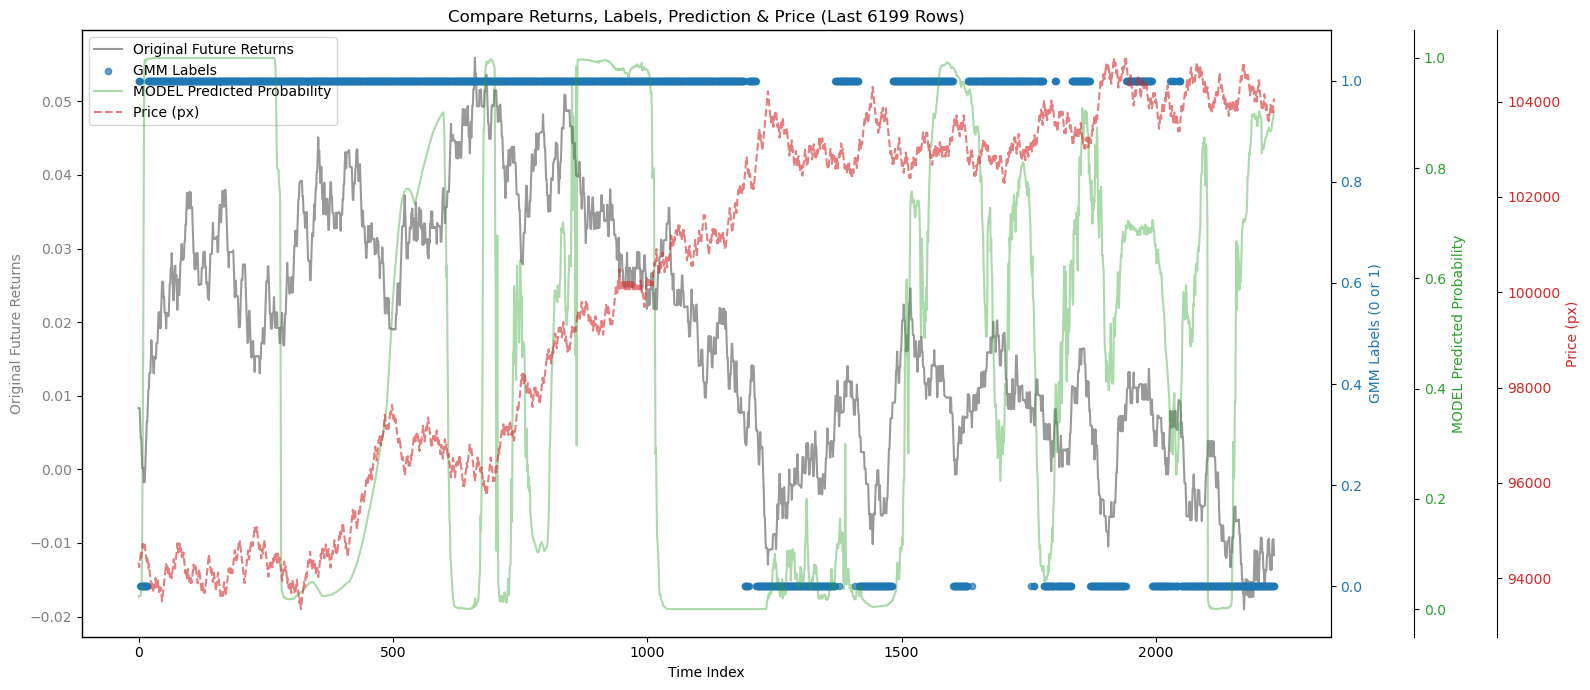


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5595
✅ 自信预测准确率: 0.5824 (阈值 0.15-0.85)
📈 出手率: 74.81%

🧮 自信预测混淆矩阵:
[[587 484]
 [172 328]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.77      0.55      0.64      1071
           1       0.40      0.66      0.50       500

    accuracy                           0.58      1571
   macro avg       0.59      0.60      0.57      1571
weighted avg       0.66      0.58      0.60      1571



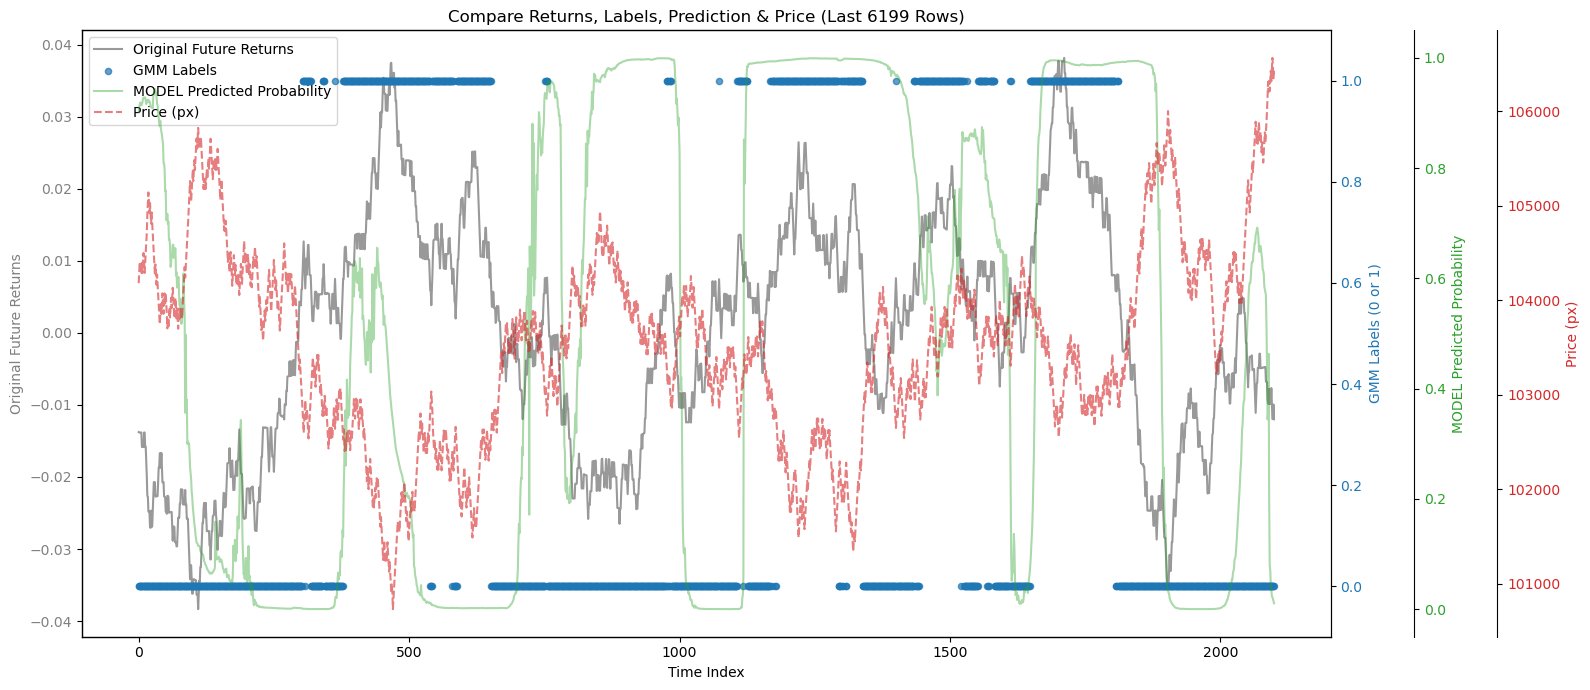

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.94288 |  0:00:00s
epoch 1  | loss: 0.48874 |  0:00:00s
epoch 2  | loss: 0.27046 |  0:00:00s
epoch 3  | loss: 0.27833 |  0:00:00s
epoch 4  | loss: 0.24696 |  0:00:00s
epoch 5  | loss: 0.19341 |  0:00:00s
epoch 6  | loss: 0.19509 |  0:00:00s
epoch 7  | loss: 0.21171 |  0:00:00s
epoch 8  | loss: 0.2247  |  0:00:01s
epoch 9  | loss: 0.18615 |  0:00:01s
epoch 10 | loss: 0.18469 |  0:00:01s
epoch 11 | loss: 0.18447 |  0:00:01s
epoch 12 | loss: 0.15594 |  0:00:01s
epoch 13 | loss: 0.16286 |  0:00:01s
epoch 14 | loss: 0.14417 |  0:00:01s
epoch 15 | loss: 0.13992 |  0:00:01s
epoch 16 | loss: 0.12681 |  0:00:01s
epoch 17 | loss: 0.13089 |  0:00:01s
epoch 18 | loss: 0.10958 |  0:00:02s
epoch 19 | loss: 0.10906 |  0:00:02s
epoch 20 | loss: 0.11138 |  0:00:02s
epoch 21 | loss: 0.11804 |  0:00:02s
epoch 22 | loss: 0.10072 |  0:00:02s
epoch 23 | loss: 0.11488 |  0:00:02s
epoch 24 | loss: 0.10311 |  0:00:02s
epoch 25 | loss: 0.09644 |  0:00:02s
epoch 26 | loss: 0.09614 |  0:00:02s
e

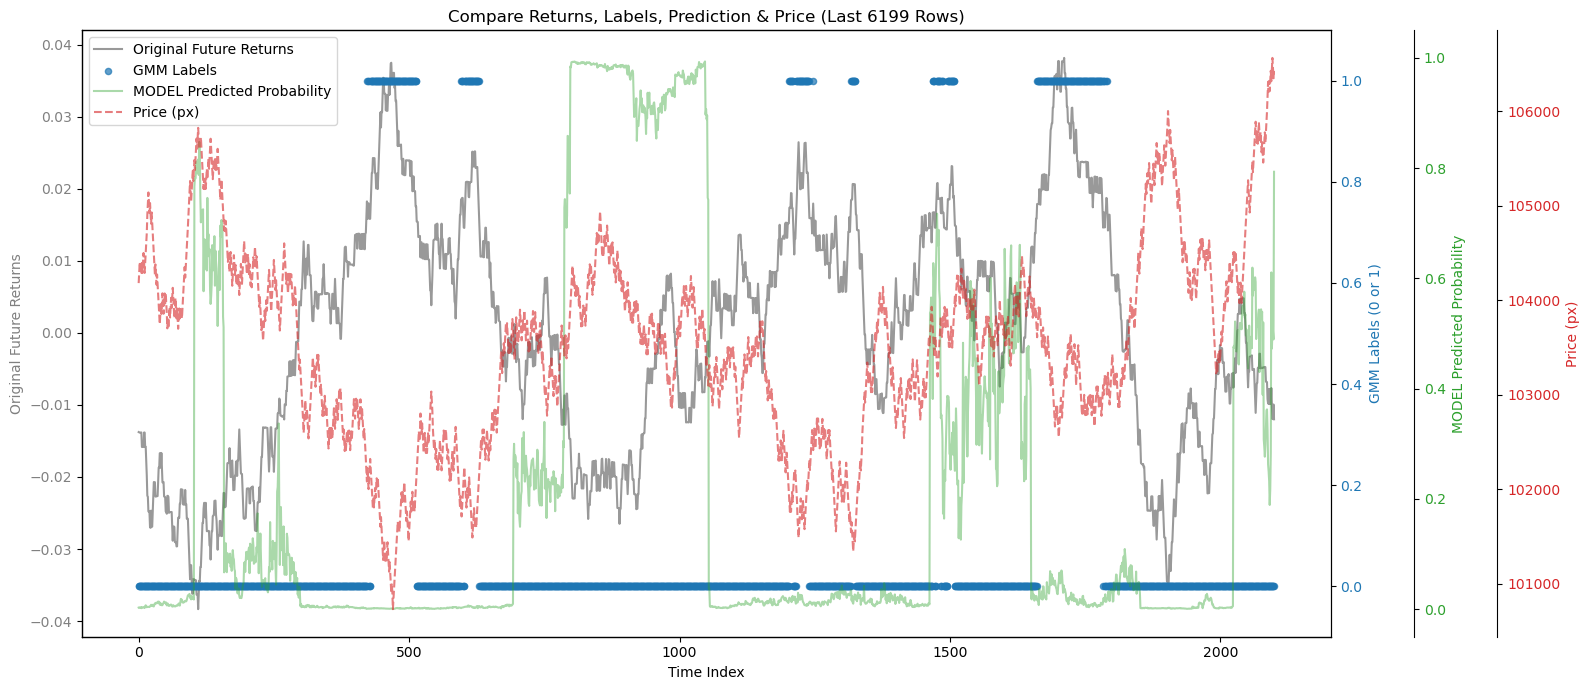


=== lgb_model 评估结果 ===
📊 全样本准确率: 0.6501
✅ 自信预测准确率: 0.7054 (阈值 0.15-0.85)
📈 出手率: 74.49%

🧮 自信预测混淆矩阵:
[[1699   75]
 [ 640   13]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      1774
           1       0.15      0.02      0.04       653

    accuracy                           0.71      2427
   macro avg       0.44      0.49      0.43      2427
weighted avg       0.57      0.71      0.61      2427



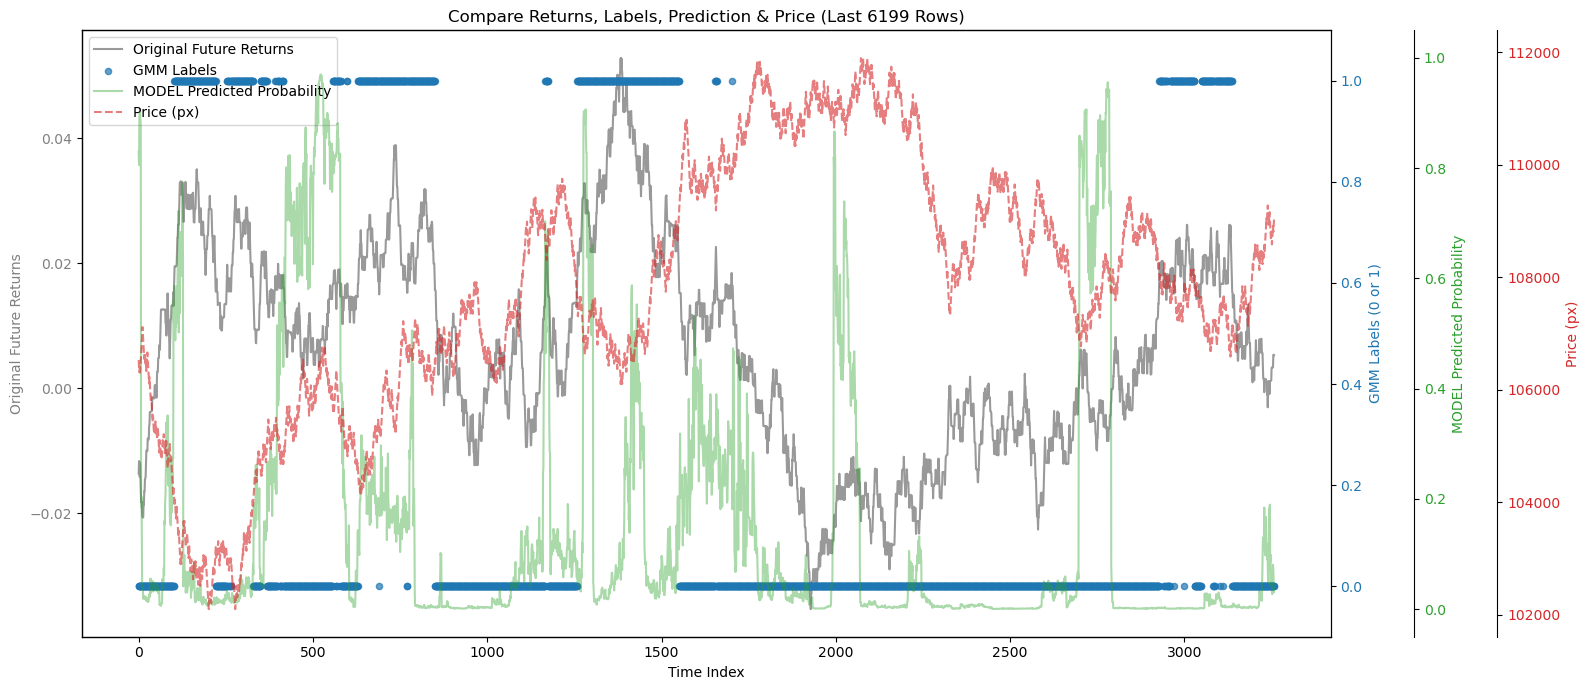


=== xgb_model 评估结果 ===
📊 全样本准确率: 0.5724
✅ 自信预测准确率: 0.5953 (阈值 0.15-0.85)
📈 出手率: 83.19%

🧮 自信预测混淆矩阵:
[[1026  421]
 [ 286   14]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.78      0.71      0.74      1447
           1       0.03      0.05      0.04       300

    accuracy                           0.60      1747
   macro avg       0.41      0.38      0.39      1747
weighted avg       0.65      0.60      0.62      1747



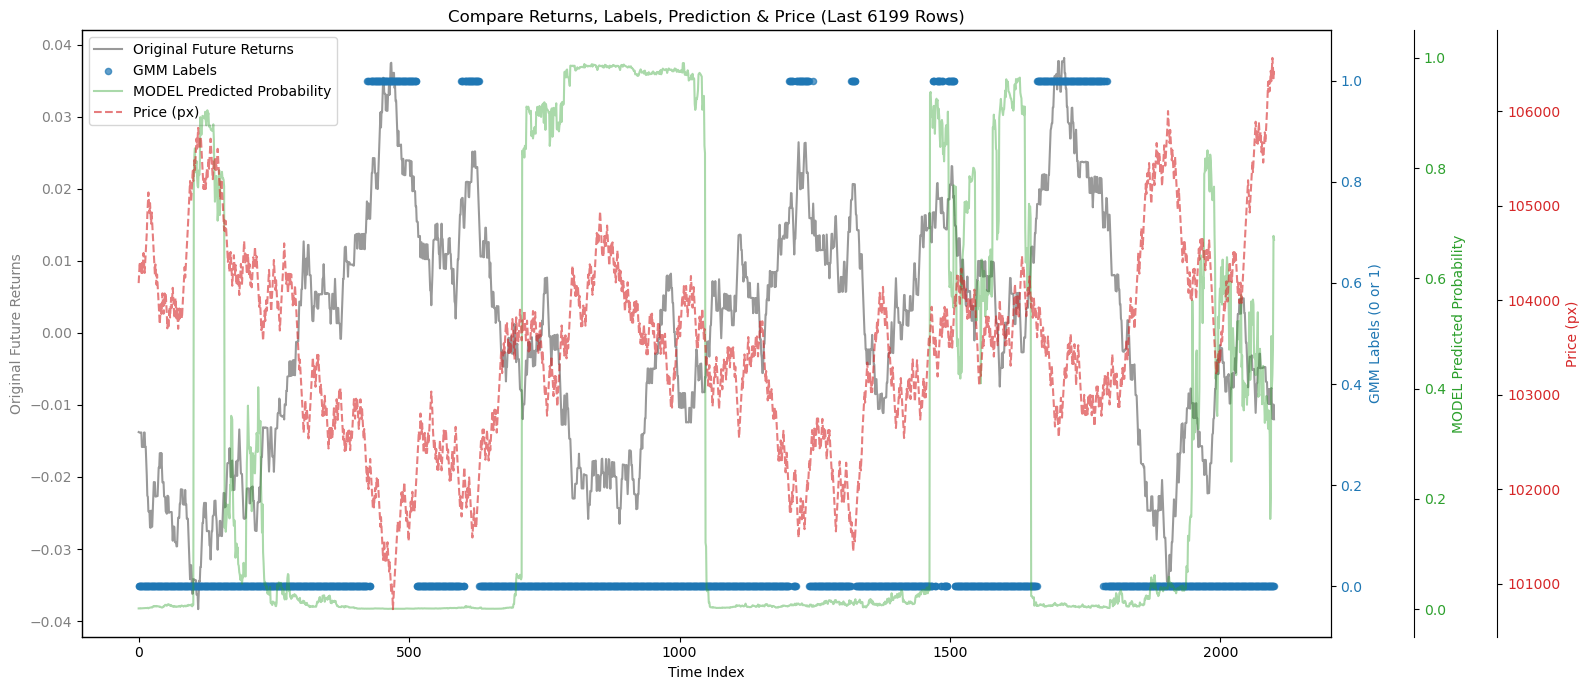


=== xgb_model 评估结果 ===
📊 全样本准确率: 0.6525
✅ 自信预测准确率: 0.7073 (阈值 0.15-0.85)
📈 出手率: 65.01%

🧮 自信预测混淆矩阵:
[[1286  100]
 [ 520  212]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.71      0.93      0.81      1386
           1       0.68      0.29      0.41       732

    accuracy                           0.71      2118
   macro avg       0.70      0.61      0.61      2118
weighted avg       0.70      0.71      0.67      2118



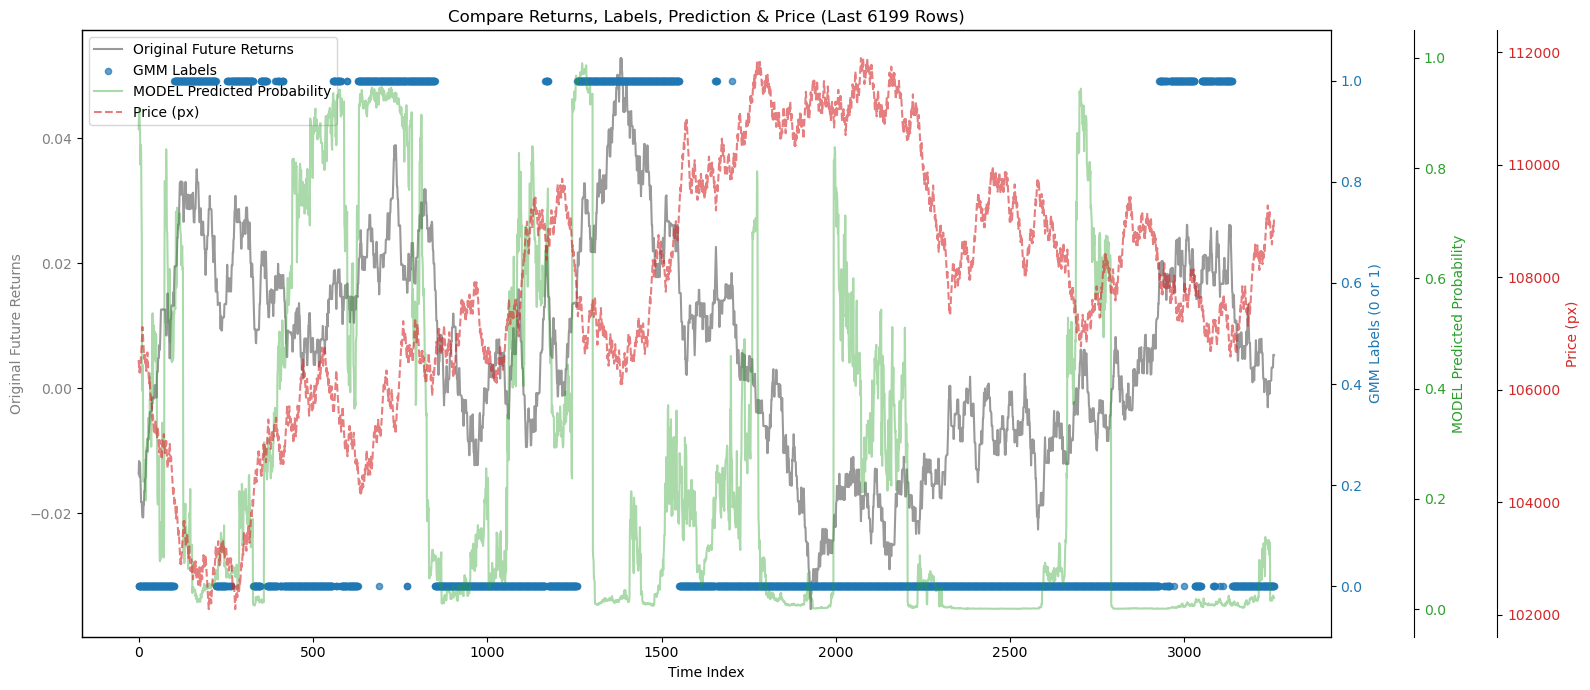

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7899  | val_0_accuracy: 0.75333 |  0:00:00s
epoch 1  | loss: 0.54928 | val_0_accuracy: 0.42857 |  0:00:01s
epoch 2  | loss: 0.49741 | val_0_accuracy: 0.35857 |  0:00:02s
epoch 3  | loss: 0.43729 | val_0_accuracy: 0.66857 |  0:00:03s
epoch 4  | loss: 0.36577 | val_0_accuracy: 0.62619 |  0:00:04s
epoch 5  | loss: 0.40679 | val_0_accuracy: 0.3681  |  0:00:05s
epoch 6  | loss: 0.36813 | val_0_accuracy: 0.34048 |  0:00:06s
epoch 7  | loss: 0.26126 | val_0_accuracy: 0.37952 |  0:00:07s
epoch 8  | loss: 0.25736 | val_0_accuracy: 0.25095 |  0:00:08s
epoch 9  | loss: 0.20677 | val_0_accuracy: 0.43524 |  0:00:09s
epoch 10 | loss: 0.21798 | val_0_accuracy: 0.44524 |  0:00:09s
epoch 11 | loss: 0.18762 | val_0_accuracy: 0.49    |  0:00:10s
epoch 12 | loss: 0.18278 | val_0_accuracy: 0.69476 |  0:00:11s
epoch 13 | loss: 0.16338 | val_0_accuracy: 0.5681  |  0:00:12s
epoch 14 | loss: 0.16251 | val_0_accuracy: 0.46667 |  0:00:13s
epoch 15 | loss: 0.14738 | val_0_accuracy: 0.62    |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.7533
✅ 自信预测准确率: nan (阈值 0.15-0.85)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


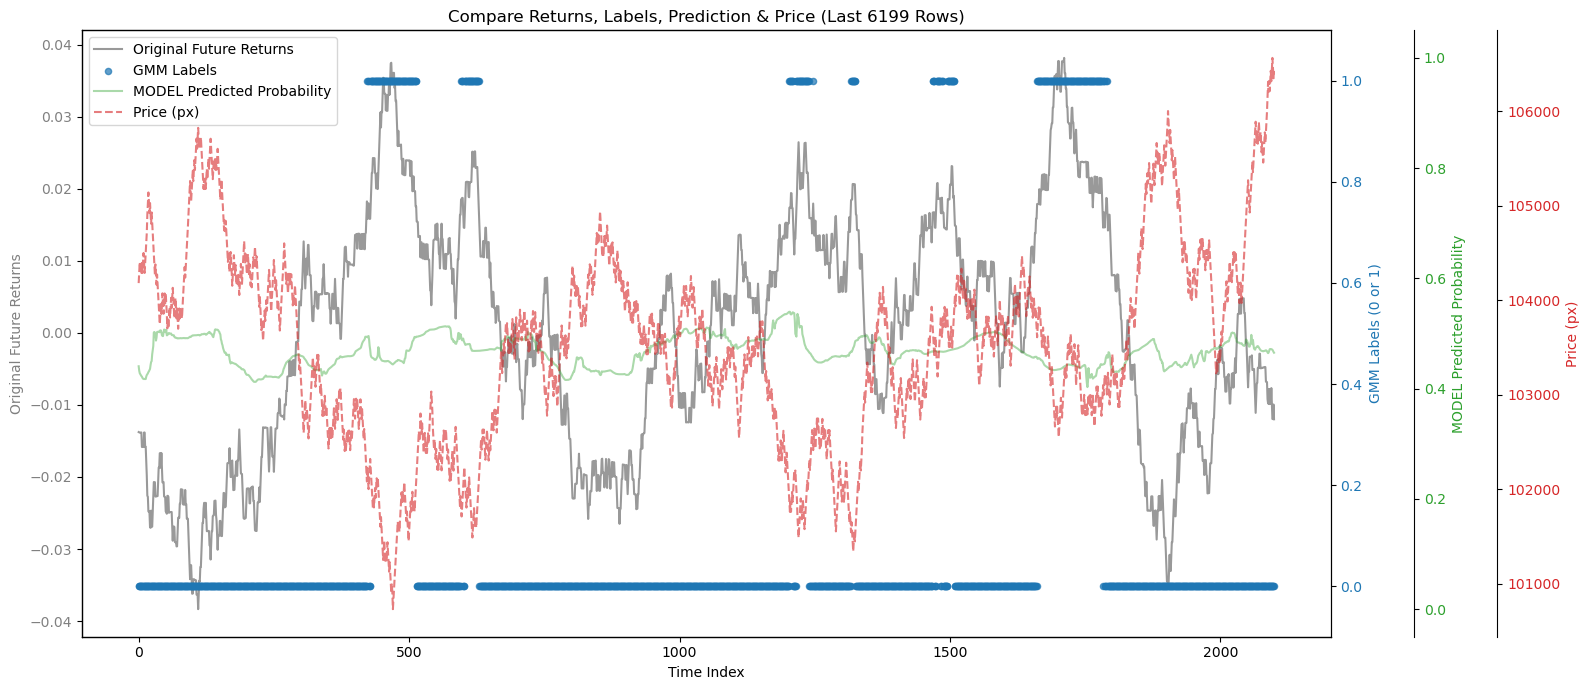


=== tabnet 评估结果 ===
📊 全样本准确率: 0.7041
✅ 自信预测准确率: nan (阈值 0.15-0.85)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


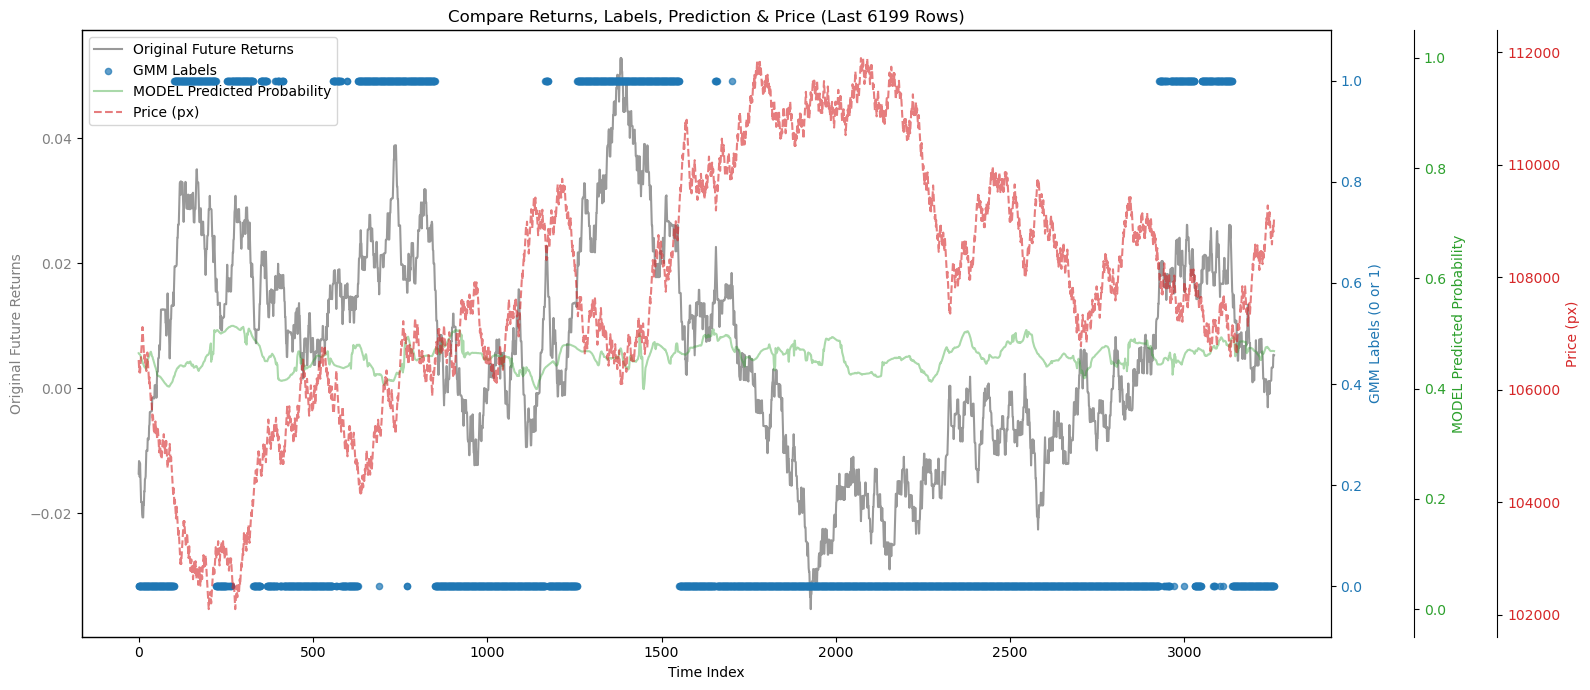

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 4.51004 |  0:00:00s
epoch 1  | loss: 1.55162 |  0:00:00s
epoch 2  | loss: 0.48103 |  0:00:00s
epoch 3  | loss: 0.23138 |  0:00:00s
epoch 4  | loss: 0.21334 |  0:00:00s
epoch 5  | loss: 0.18091 |  0:00:00s
epoch 6  | loss: 0.164   |  0:00:00s
epoch 7  | loss: 0.1353  |  0:00:00s
epoch 8  | loss: 0.12239 |  0:00:01s
epoch 9  | loss: 0.11223 |  0:00:01s
epoch 10 | loss: 0.10582 |  0:00:01s
epoch 11 | loss: 0.09719 |  0:00:01s
epoch 12 | loss: 0.10153 |  0:00:01s
epoch 13 | loss: 0.10136 |  0:00:01s
epoch 14 | loss: 0.10489 |  0:00:01s
epoch 15 | loss: 0.09501 |  0:00:01s
epoch 16 | loss: 0.08145 |  0:00:02s
epoch 17 | loss: 0.08543 |  0:00:02s
epoch 18 | loss: 0.08473 |  0:00:02s
epoch 19 | loss: 0.08389 |  0:00:02s
epoch 20 | loss: 0.07024 |  0:00:02s
epoch 21 | loss: 0.08126 |  0:00:02s
epoch 22 | loss: 0.07228 |  0:00:02s
epoch 23 | loss: 0.07283 |  0:00:02s
epoch 24 | loss: 0.071   |  0:00:02s
epoch 25 | loss: 0.07424 |  0:00:03s
epoch 26 | loss: 0.07144 |  0:00:03s
e

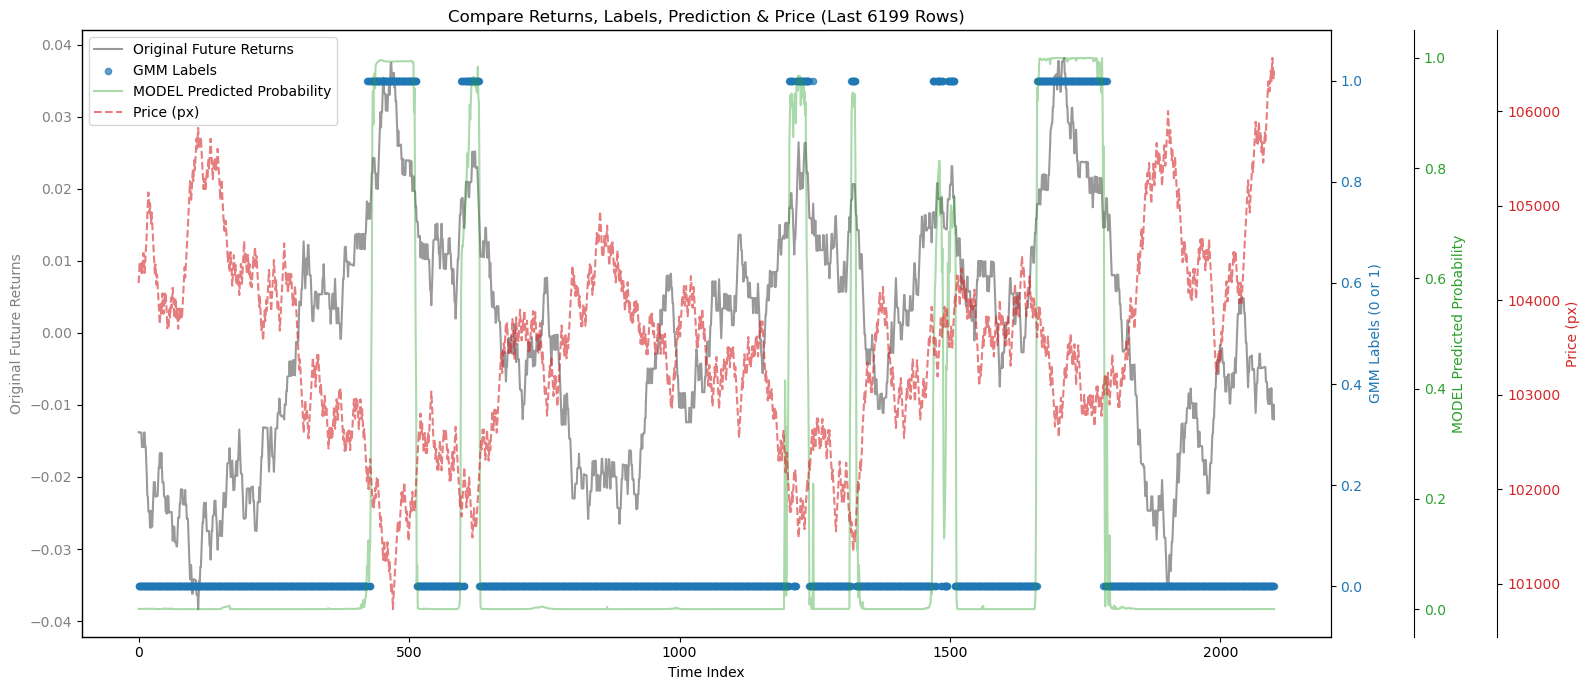


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6624
✅ 自信预测准确率: 0.6674 (阈值 0.15-0.85)
📈 出手率: 94.51%

🧮 自信预测混淆矩阵:
[[2053  118]
 [ 906    2]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      2171
           1       0.02      0.00      0.00       908

    accuracy                           0.67      3079
   macro avg       0.36      0.47      0.40      3079
weighted avg       0.49      0.67      0.57      3079



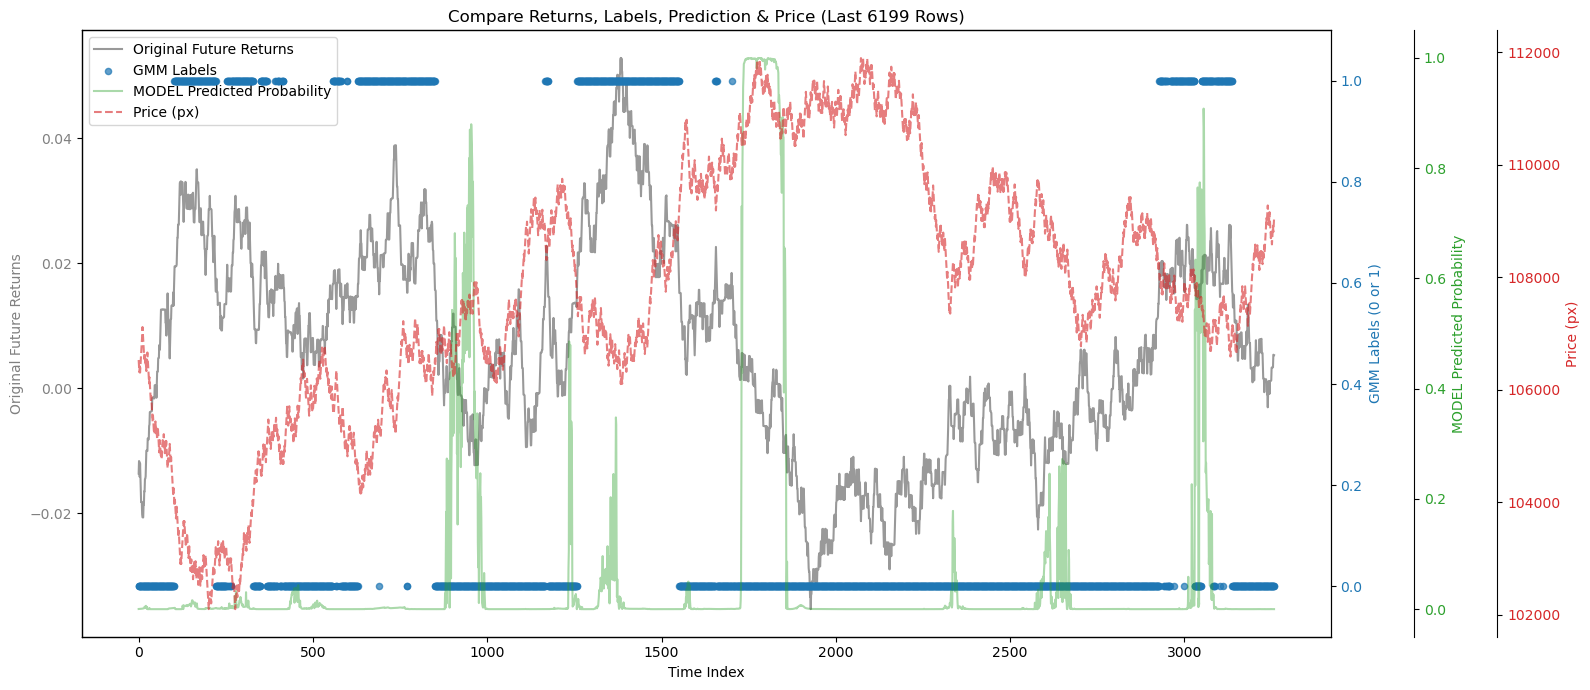

Test Week 5 Evaluation Completed
Fold 2: Train 2~5, Val 6, Test 7
Train: 2025-04-21 00:06:22.525000 to 2025-05-18 23:59:34.191000
Val: 2025-05-19 00:00:37.074000 to 2025-05-25 23:57:24.031000
Test: 2025-05-26 00:01:11.960000 to 2025-05-31 00:13:34.179000
GMM 分量均值: [-0.00324253  0.02355544]
上涨标签: 1, 下跌标签: 0

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: -0.003243) => 二元标签: 0
GMM 内部标签 1 (均值: 0.023555) => 二元标签: 1

--- 示例标签 ---
训练集原始收益: [0.01692712 0.01471548 0.01243342 0.0102545  0.01025795 0.01022109
 0.00810868 0.00805811 0.00798432 0.00587873]
训练集GMM标签: [1 1 0 0 0 0 0 0 0 0]
训练集二元标签: [1 1 0 0 0 0 0 0 0 0]

测试集原始收益: [0.0080186  0.00596204 0.00800763 0.00598318 0.00805954 0.00811877
 0.00603282 0.00603682 0.00602973 0.00399286]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]

=== lgb_model 评估结果 ===
📊 全样本准确率: 0.6593
✅ 自信预测准确率: 0.7390 (阈值 0.15-0.85)
📈 出手率: 63.63%

🧮 自信预测混淆矩阵:
[[869 476]
 [ 65 663]]

📝 分类报告:
              precision    recall  f1-score   support

           0  

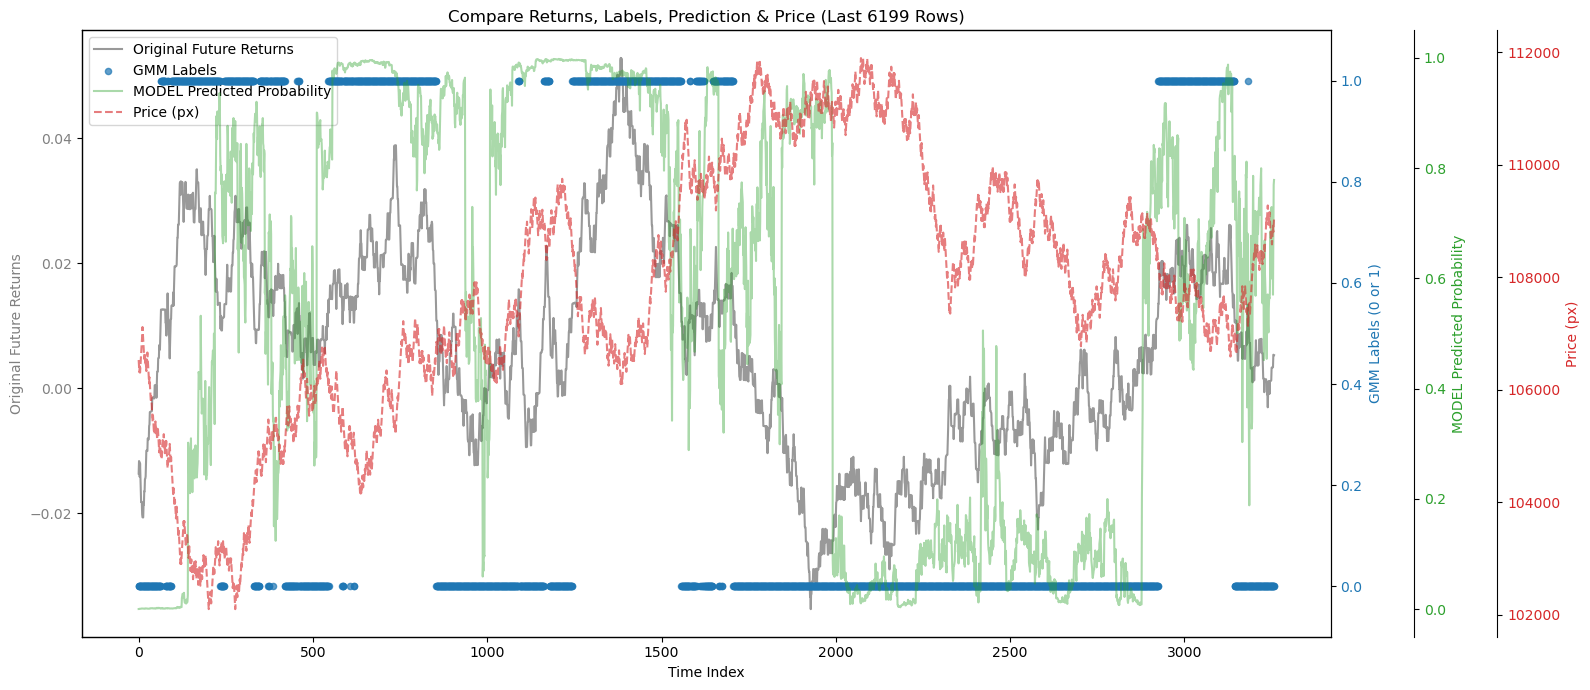

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r


=== lgb_model 评估结果 ===
📊 全样本准确率: 0.2204
✅ 自信预测准确率: 0.2023 (阈值 0.15-0.85)
📈 出手率: 72.16%

🧮 自信预测混淆矩阵:
[[249 982]
 [  0   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      0.20      0.34      1231
           1       0.00      0.00      0.00         0

    accuracy                           0.20      1231
   macro avg       0.50      0.10      0.17      1231
weighted avg       1.00      0.20      0.34      1231



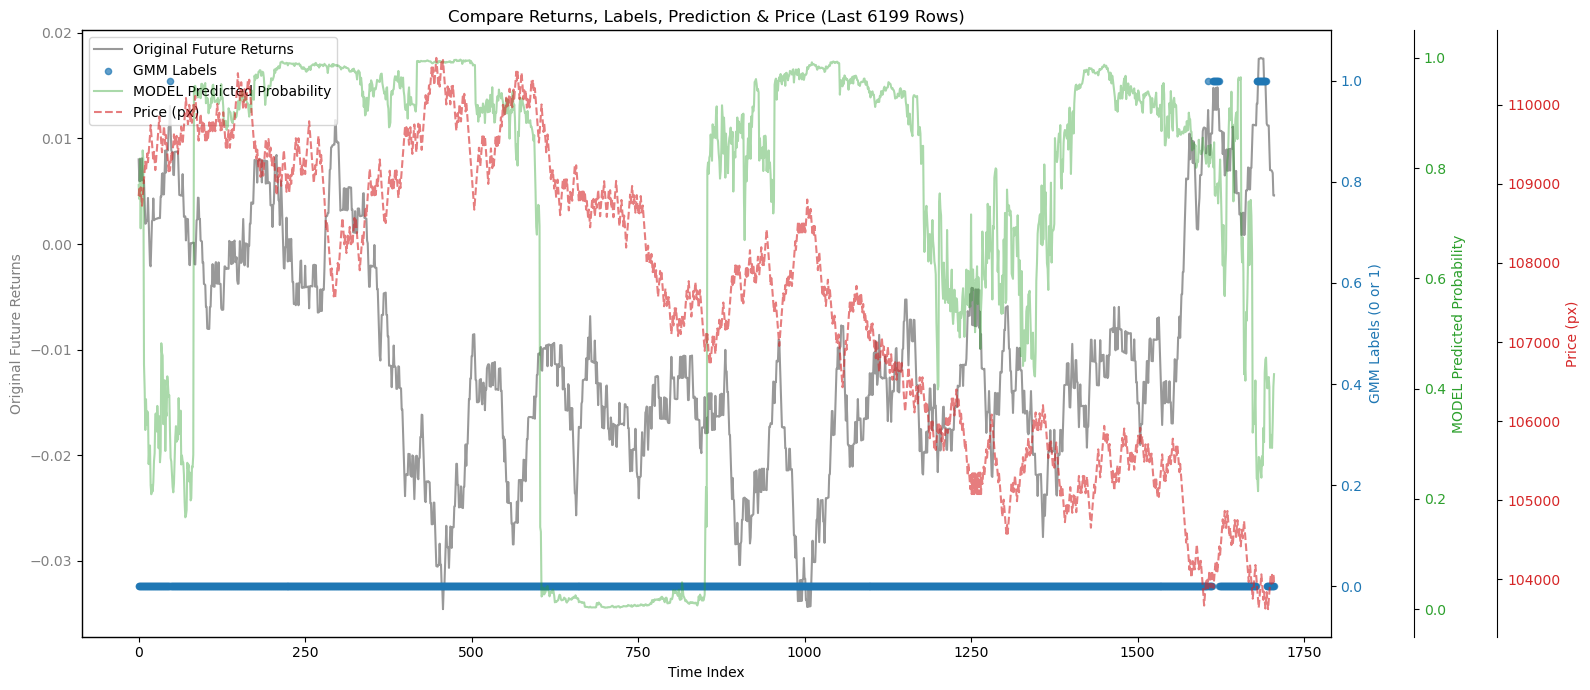


=== xgb_model 评估结果 ===
📊 全样本准确率: 0.6664
✅ 自信预测准确率: 0.7454 (阈值 0.15-0.85)
📈 出手率: 61.11%

🧮 自信预测混淆矩阵:
[[793 439]
 [ 68 691]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.92      0.64      0.76      1232
           1       0.61      0.91      0.73       759

    accuracy                           0.75      1991
   macro avg       0.77      0.78      0.74      1991
weighted avg       0.80      0.75      0.75      1991



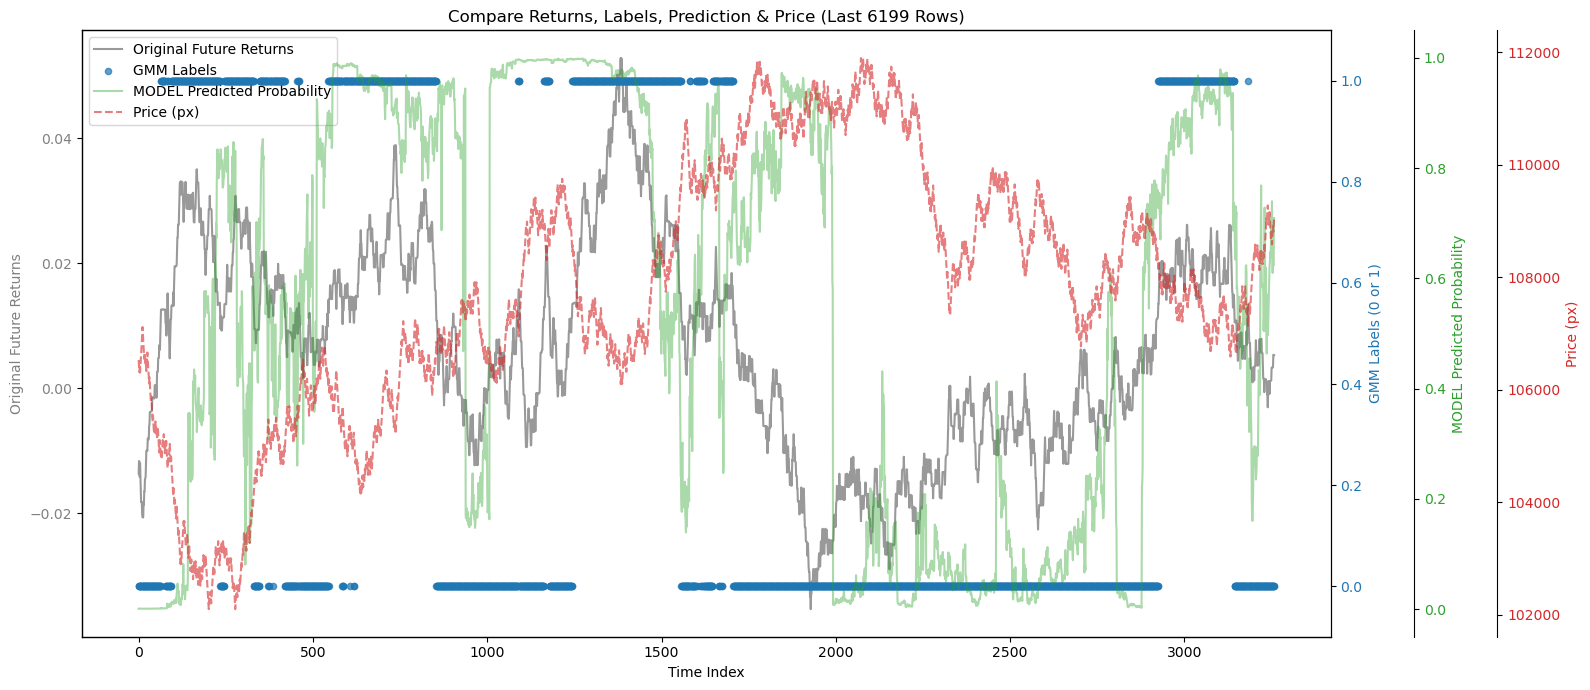


=== xgb_model 评估结果 ===
📊 全样本准确率: 0.2122
✅ 自信预测准确率: 0.2325 (阈值 0.15-0.85)
📈 出手率: 67.82%

🧮 自信预测混淆矩阵:
[[256 887]
 [  1  13]]

📝 分类报告:
              precision    recall  f1-score   support

           0       1.00      0.22      0.37      1143
           1       0.01      0.93      0.03        14

    accuracy                           0.23      1157
   macro avg       0.51      0.58      0.20      1157
weighted avg       0.98      0.23      0.36      1157



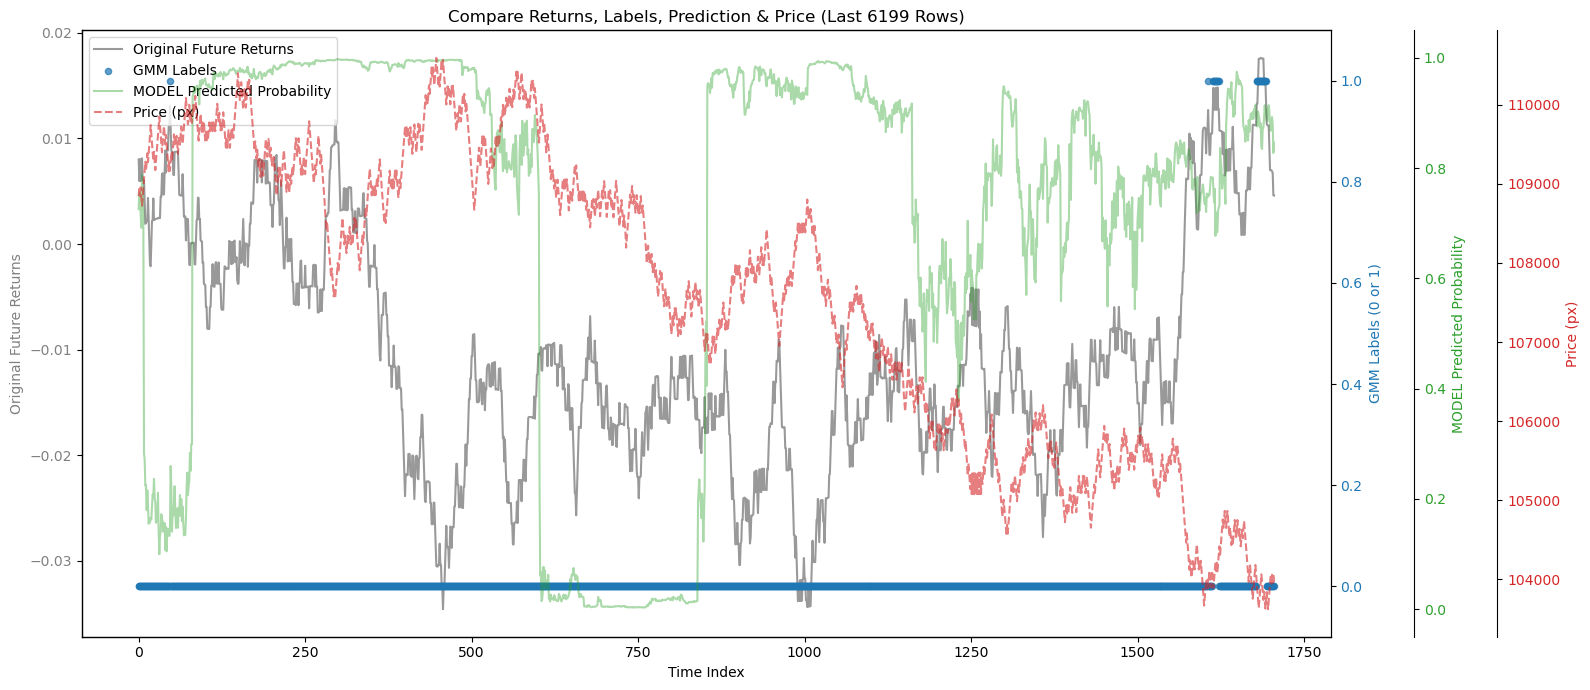

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90166 | val_0_accuracy: 0.60068 |  0:00:00s
epoch 1  | loss: 0.64618 | val_0_accuracy: 0.61848 |  0:00:01s
epoch 2  | loss: 0.58793 | val_0_accuracy: 0.49754 |  0:00:02s
epoch 3  | loss: 0.53975 | val_0_accuracy: 0.61449 |  0:00:03s
epoch 4  | loss: 0.51529 | val_0_accuracy: 0.60405 |  0:00:04s
epoch 5  | loss: 0.49666 | val_0_accuracy: 0.61326 |  0:00:04s
epoch 6  | loss: 0.50056 | val_0_accuracy: 0.49386 |  0:00:05s
epoch 7  | loss: 0.44122 | val_0_accuracy: 0.54758 |  0:00:06s
epoch 8  | loss: 0.45122 | val_0_accuracy: 0.61848 |  0:00:07s
epoch 9  | loss: 0.42677 | val_0_accuracy: 0.6415  |  0:00:08s
epoch 10 | loss: 0.3722  | val_0_accuracy: 0.67894 |  0:00:09s
epoch 11 | loss: 0.37024 | val_0_accuracy: 0.62983 |  0:00:09s
epoch 12 | loss: 0.33561 | val_0_accuracy: 0.60068 |  0:00:10s
epoch 13 | loss: 0.3344  | val_0_accuracy: 0.55341 |  0:00:11s
epoch 14 | loss: 0.3036  | val_0_accuracy: 0.55494 |  0:00:12s
epoch 15 | loss: 0.25851 | val_0_accuracy: 0.53622 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6789
✅ 自信预测准确率: 0.6386 (阈值 0.15-0.85)
📈 出手率: 46.62%

🧮 自信预测混淆矩阵:
[[945  45]
 [504  25]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.65      0.95      0.77       990
           1       0.36      0.05      0.08       529

    accuracy                           0.64      1519
   macro avg       0.50      0.50      0.43      1519
weighted avg       0.55      0.64      0.53      1519



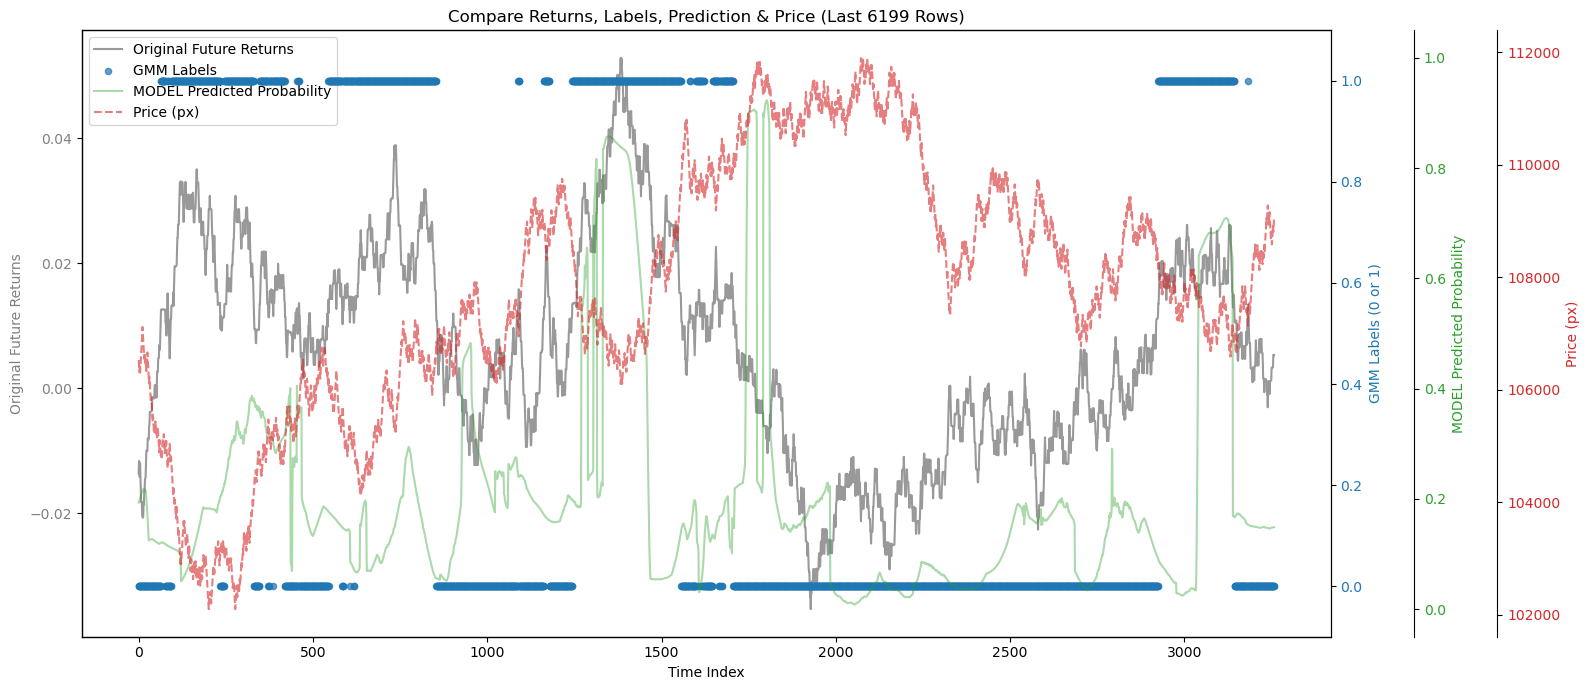

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.


=== tabnet 评估结果 ===
📊 全样本准确率: 0.9683
✅ 自信预测准确率: 0.9476 (阈值 0.15-0.85)
📈 出手率: 27.96%

🧮 自信预测混淆矩阵:
[[452   0]
 [ 25   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       452
           1       0.00      0.00      0.00        25

    accuracy                           0.95       477
   macro avg       0.47      0.50      0.49       477
weighted avg       0.90      0.95      0.92       477



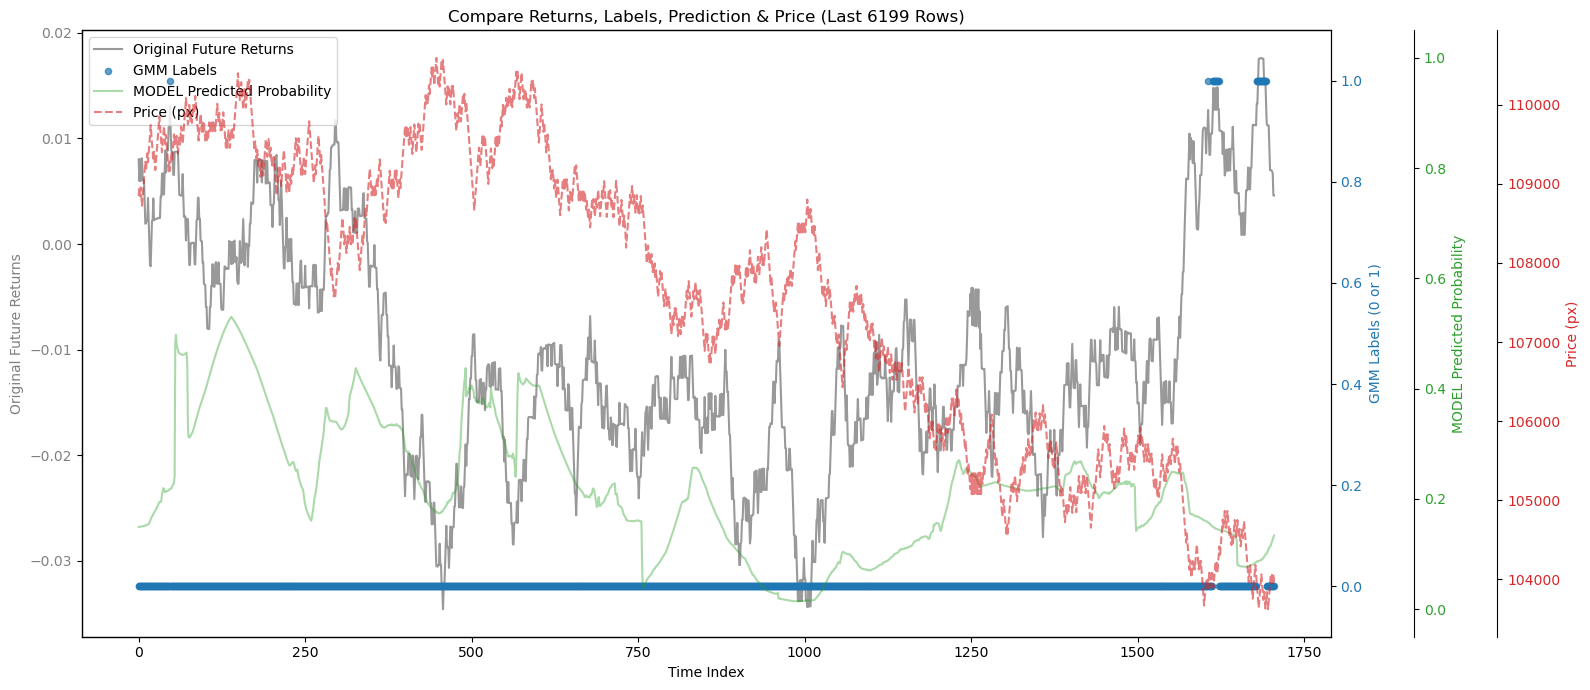

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.52552 |  0:00:00s
epoch 1  | loss: 0.39014 |  0:00:00s
epoch 2  | loss: 0.25067 |  0:00:00s
epoch 3  | loss: 0.22614 |  0:00:00s
epoch 4  | loss: 0.19649 |  0:00:00s
epoch 5  | loss: 0.19917 |  0:00:00s
epoch 6  | loss: 0.18599 |  0:00:01s
epoch 7  | loss: 0.17136 |  0:00:01s
epoch 8  | loss: 0.16758 |  0:00:01s
epoch 9  | loss: 0.15341 |  0:00:01s
epoch 10 | loss: 0.14268 |  0:00:01s
epoch 11 | loss: 0.14376 |  0:00:01s
epoch 12 | loss: 0.14533 |  0:00:01s
epoch 13 | loss: 0.13258 |  0:00:02s
epoch 14 | loss: 0.13107 |  0:00:02s
epoch 15 | loss: 0.12223 |  0:00:02s
epoch 16 | loss: 0.12752 |  0:00:02s
epoch 17 | loss: 0.12479 |  0:00:02s
epoch 18 | loss: 0.12123 |  0:00:02s
epoch 19 | loss: 0.12554 |  0:00:03s
epoch 20 | loss: 0.11586 |  0:00:03s
epoch 21 | loss: 0.11787 |  0:00:03s
epoch 22 | loss: 0.10969 |  0:00:03s
epoch 23 | loss: 0.1155  |  0:00:03s
epoch 24 | loss: 0.10844 |  0:00:03s
epoch 25 | loss: 0.10706 |  0:00:03s
epoch 26 | loss: 0.12517 |  0:00:04s
e

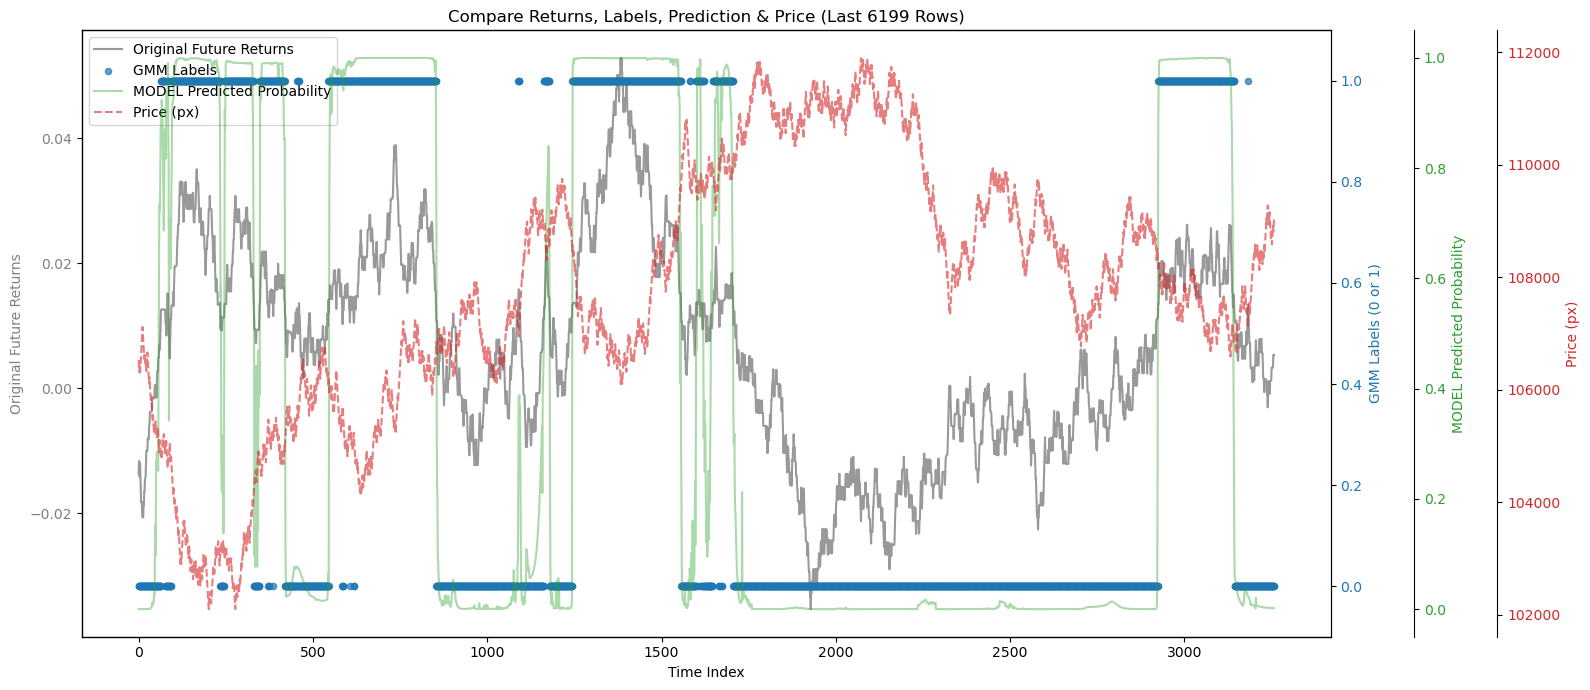


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4572
✅ 自信预测准确率: 0.4567 (阈值 0.15-0.85)
📈 出手率: 71.75%

🧮 自信预测混淆矩阵:
[[559 658]
 [  7   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.99      0.46      0.63      1217
           1       0.00      0.00      0.00         7

    accuracy                           0.46      1224
   macro avg       0.49      0.23      0.31      1224
weighted avg       0.98      0.46      0.62      1224



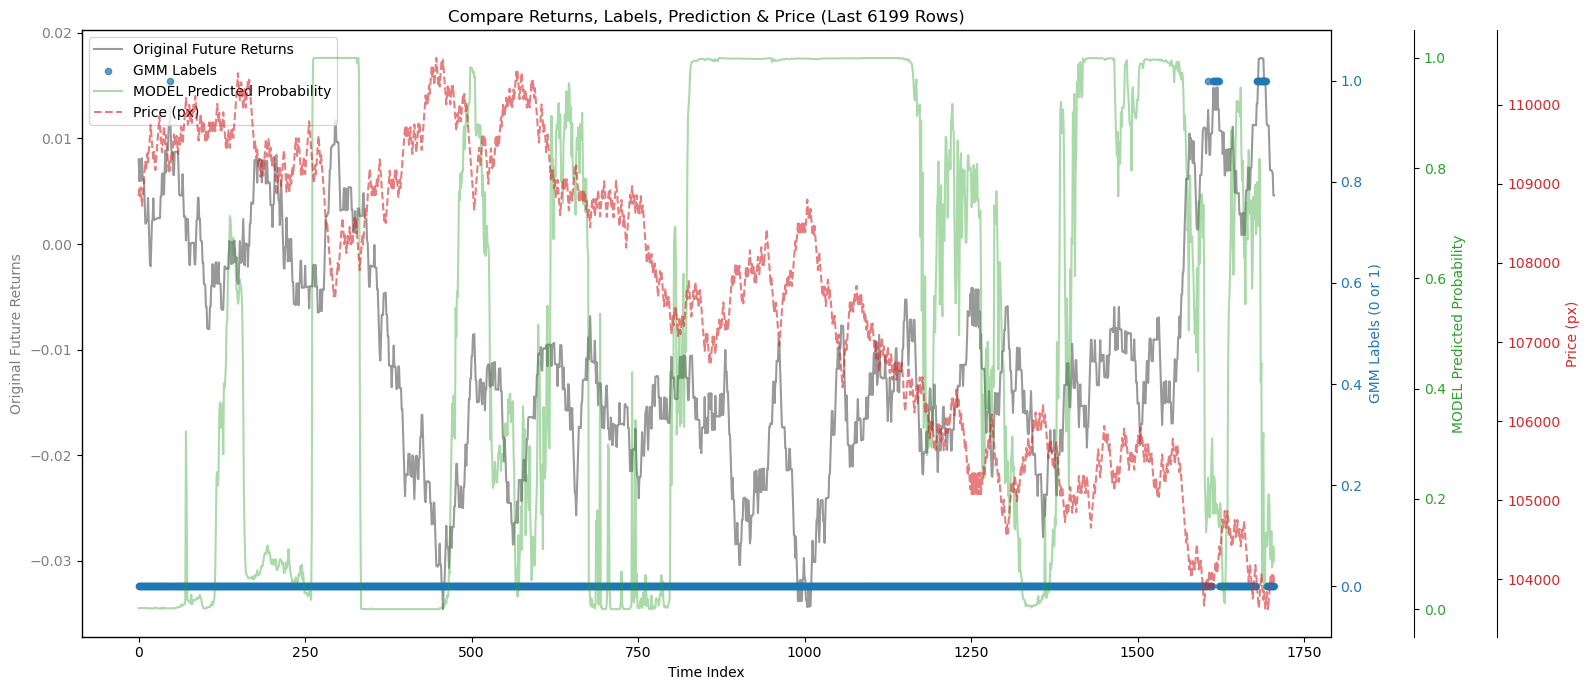

Test Week 6 Evaluation Completed


In [679]:
n_train_weeks = 4 # 可配置
n_val_weeks = 1    # 一般 1 周验证
n_test_weeks = 1   # 后 1 周做 test

exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{avg_steps_pct}"
feature_cols = [
    col for col in origin_df.columns
    if col.endswith("_scaled") 
        # and (col.startswith("z_") or col.startswith("raw_")) 
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "px"
]
# feature_cols = ["z_oi_di_scaled"]
results = []

tab_inc = None
tab_inc_flag = 0

for i in range(len(weekly_dataframes) - n_train_weeks - n_val_weeks - n_test_weeks + 1):
    train_dfs = weekly_dataframes[i : i + n_train_weeks]
    val_dfs = weekly_dataframes[i + n_train_weeks : i + n_train_weeks + n_val_weeks]
    test_dfs = weekly_dataframes[i + n_train_weeks + n_val_weeks : i + n_train_weeks + n_val_weeks + n_test_weeks]
    
    train_df = pl.concat(train_dfs)
    val_df = pl.concat(val_dfs)
    test_df = pl.concat(test_dfs)

    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_weeks-1}, Val {i+n_train_weeks}, Test {i+n_train_weeks+1}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])
    print("Test:", test_df['timestamp_dt'][0], "to", test_df['timestamp_dt'][-1])
    
    # 处理 train
    train_df_processed = train_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_train = train_df_processed[feature_cols]
    y_train = train_df_processed[target_col]
    px_train = train_df_processed['px']

    # 处理 val
    val_df_processed = val_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_val = val_df_processed[feature_cols]
    y_val = val_df_processed[target_col]
    px_val = val_df_processed['px']

    # 处理 test
    test_df_processed = test_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_test = test_df_processed[feature_cols]
    y_test = test_df_processed[target_col]
    px_test = test_df_processed['px']
    
    
    y_train_bin, y_val_bin, y_test_bin, gmm_model = gmm_label_binarize(y_train, y_val, y_test, verbose=True)

    # modellllllll
    up_thresh = 0.15
    lower_thresh = 0.85
    
    # #LGBM
    lgb_model = lgb.LGBMClassifier(n_estimators=2000, learning_rate=0.005, max_depth=9, verbose=-1)
    lgb_model.fit(
        X_train, y_train_bin,
        eval_set=[(X_val, y_val_bin)],
        eval_metric='binary_logloss',
    )
    
    lgb_eval = evaluate_with_confidence(
        y_true=y_val_bin,
        y_pred_proba=lgb_model.predict_proba(X_val)[:, 1],
        model_name="lgb_model",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_val, y_val_bin, lgb_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    
    lgb_eval = evaluate_with_confidence(
        y_true=y_test_bin,
        y_pred_proba=lgb_model.predict_proba(X_test)[:, 1],
        model_name="lgb_model",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_test, y_test_bin, lgb_model.predict_proba(X_test)[:, 1], px_test, n=6199)


    # # CAT
    # cat_model = CatBoostClassifier(iterations=2000, learning_rate=0.005, depth=9, verbose=0)
    # cat_model.fit(
    #     X_train, y_train_bin,
    # )

    # cat_eval = evaluate_with_confidence(
    #     y_true=y_val_bin,
    #     y_pred_proba=cat_model.predict_proba(X_val)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val_bin, cat_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    
    # cat_eval = evaluate_with_confidence(
    #     y_true=y_test_bin,
    #     y_pred_proba=cat_model.predict_proba(X_test)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test_bin, cat_model.predict_proba(X_test)[:, 1], px_test, n=6199)

    # XGB
    xgb_model = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.005, max_depth=9, verbosity=0, use_label_encoder=False)
    xgb_model.fit(
        X_train, y_train_bin,
    )

    xgb_eval = evaluate_with_confidence(
        y_true=y_val_bin,
        y_pred_proba=xgb_model.predict_proba(X_val)[:, 1],
        model_name="xgb_model",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_val, y_val_bin, xgb_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    

    xgb_eval = evaluate_with_confidence(
        y_true=y_test_bin,
        y_pred_proba=xgb_model.predict_proba(X_test)[:, 1],
        model_name="xgb_model",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_test, y_test_bin, xgb_model.predict_proba(X_test)[:, 1], px_test, n=6199)

    
    # Label Encode y（如果是0/1就不用）
    y_train_enc = y_train_bin.astype(int)
    y_val_enc = y_val_bin.astype(int)
    
    # TabNet 训练
    tabnet = TabNetClassifier(
        n_d=16,
        n_a=16,
        n_steps=7,
        device_name='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=1,
    )
    tabnet.fit(
        X_train=X_train.values, y_train=y_train_enc,
        eval_set=[(X_val.values, y_val_enc)],
        eval_metric=['accuracy'],
        max_epochs=300,
        patience=30,
        batch_size=512,
        virtual_batch_size=256,
    )

    tabnet_eval = evaluate_with_confidence(
        y_true=y_val_bin,
        y_pred_proba=tabnet.predict_proba(X_val.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_val, y_val_bin, tabnet.predict_proba(X_val.values)[:, 1], px_val, n=6199)


    tabnet_eval = evaluate_with_confidence(
        y_true=y_test_bin,
        y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_test, y_test_bin, tabnet.predict_proba(X_test.values)[:, 1], px_test, n=6199)


    # TabNet_incremental 训练
    if tab_inc_flag == 0:
        tab_inc_flag = 1
        tab_inc = TabNetClassifier(
            n_d=16,
            n_a=16,
            n_steps=7,
            device_name='cuda' if torch.cuda.is_available() else 'cpu',
            verbose=1,
        )
        tab_inc.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            eval_metric=['accuracy'],
            max_epochs=300,
            patience=30,
            batch_size=512,
            virtual_batch_size=256,
        )
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_val_bin,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_val, y_val_bin, tab_inc.predict_proba(X_val.values)[:, 1], px_val, n=6199)
    
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test_bin,
            y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test_bin, tab_inc.predict_proba(X_test.values)[:, 1], px_test, n=6199)
        tab_inc.fit(X_val.values, y_val_enc, warm_start=True)

    else:
        tab_inc.fit(X_val.values, y_val_enc, warm_start=True)
        
        tabnet_eval = evaluate_with_confidence(
            y_true=y_val_bin,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_val, y_val_bin, tab_inc.predict_proba(X_val.values)[:, 1], px_val, n=6199)
    
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test_bin,
            y_pred_proba=tab_inc.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test_bin, tab_inc.predict_proba(X_test.values)[:, 1], px_test, n=6199)
    
    week_results = {
        'train_period': f"{train_df['timestamp_dt'][0]} to {train_df['timestamp_dt'][-1]}",
        'test_period': f"{test_df['timestamp_dt'][0]} to {test_df['timestamp_dt'][-1]}",
        'LGBM': lgb_eval,
        # 'CatBoost': cat_model,
        'XGBoost': xgb_eval,
        'TabNet': tabnet_eval,
    }
    
    results.append(week_results)
    print(f"Test Week {i+n_train_weeks} Evaluation Completed")

    

In [625]:
import polars as pl

def forward_corr(df: pl.DataFrame, col1: str, col2: str, n: int) -> float:
    shifted = df.with_columns([
        pl.col(col2).shift(-n).alias(f"{col2}_future")
    ])
    return shifted.select([
        pl.corr(pl.col(col1), pl.col(f"{col2}_future"))
    ]).item()

# # 示例 DataFrame
# df = pl.DataFrame({
#     "factor": [0.1, 0.2, 0.3, 0.4, 0.5],
#     "return": [0.01, -0.02, 0.03, 0.01, -0.01]
# })

df = origin_df.with_columns([
    pl.col("px")
    .pct_change()
    .shift(-1)  # 向未来看一格
    .sign()
    .alias("future_direction")
])

velo_col = f"ts_duration"
window = 200
df = df.with_columns([
    (pl.col(velo_col) * pl.col("future_direction")).alias("target_col")
]).drop_nulls()
print(df["target_col"])
print(df["bs_imbalance"])

forward_corr(df, f"bs_imba_rol_mean_{window}", f"px_pct_rol_sum_{window}", n=10)


shape: (6_727,)
Series: 'target_col' [f64]
[
	-4.986e6
	970000.0
	-1.3794e7
	8.272e6
	-1.9109e7
	…
	2.0538e9
	-3.3207e8
	-9.8586e8
	1.6281e9
	2.4515e9
]
shape: (6_727,)
Series: 'bs_imbalance' [f64]
[
	188.57
	-276.904
	279.527
	42.742
	-10.968
	…
	-64.47
	363.659
	-150.271
	-354.499
	33.372
]


0.5161504480783088

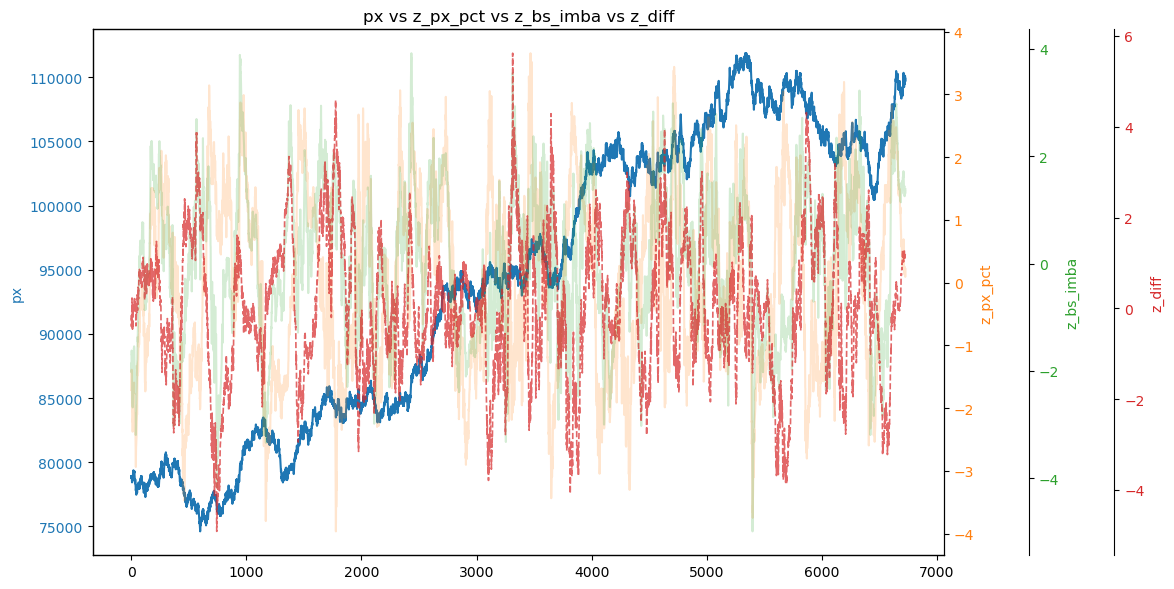

In [627]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# 数据准备
plot_df = df.select([
    f"z_bs_imba_rol_mean_{window}",
    f"z_px_pct_rol_sum_{window}",
    "px"
]).to_pandas().iloc[:]

# 计算 z-score 差值
plot_df["z_diff"] = plot_df[f"z_bs_imba_rol_mean_{window}"] - plot_df[f"z_px_pct_rol_sum_{window}"]
plot_df = pl.from_pandas(plot_df)
plot_df = rolling_mean_tanh_normalize(plot_df, 100).to_pandas()

# 开始画图
fig, ax1 = plt.subplots(figsize=(12, 6))

# 第一条 y 轴：px
ax1.set_ylabel("px", color="tab:blue")
ax1.plot(plot_df.index, plot_df["px"], label="px", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# 第二条 y 轴：z_px_pct
ax2 = ax1.twinx()
ax2.set_ylabel("z_px_pct", color="tab:orange")
ax2.plot(plot_df.index, plot_df[f"z_px_pct_rol_sum_{window}"], label="z_px_pct", color="tab:orange", alpha=0.2)
ax2.tick_params(axis='y', labelcolor="tab:orange")

# 第三条 y 轴：z_bs_imba
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.set_ylabel("z_bs_imba", color="tab:green")
ax3.plot(plot_df.index, plot_df[f"z_bs_imba_rol_mean_{window}"], label="z_bs_imba", color="tab:green", alpha=0.2)
ax3.tick_params(axis='y', labelcolor="tab:green")

# 第四条 y 轴：差值 z_diff
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.2))  # 再向右偏一点
ax4.set_frame_on(True)
ax4.patch.set_visible(False)
ax4.set_ylabel("z_diff", color="tab:red")
ax4.plot(plot_df.index, plot_df["z_diff"], label="z_diff_scaled", color="tab:red", linestyle="--", linewidth=1.2, alpha=0.7)
ax4.tick_params(axis='y', labelcolor="tab:red")

# 美化
plt.title("px vs z_px_pct vs z_bs_imba vs z_diff")
fig.tight_layout()
plt.show()



=== Strategy Summary (TREND) | Rolling: True ===
Total Trades      : 378
Winning Rate      : 55.82%
Strategy Return   : -45.56%
Benchmark Return  : 39.26%
Max Drawdown      : -47.61% at index 6524
Long Trades       : 194
Short Trades      : 184


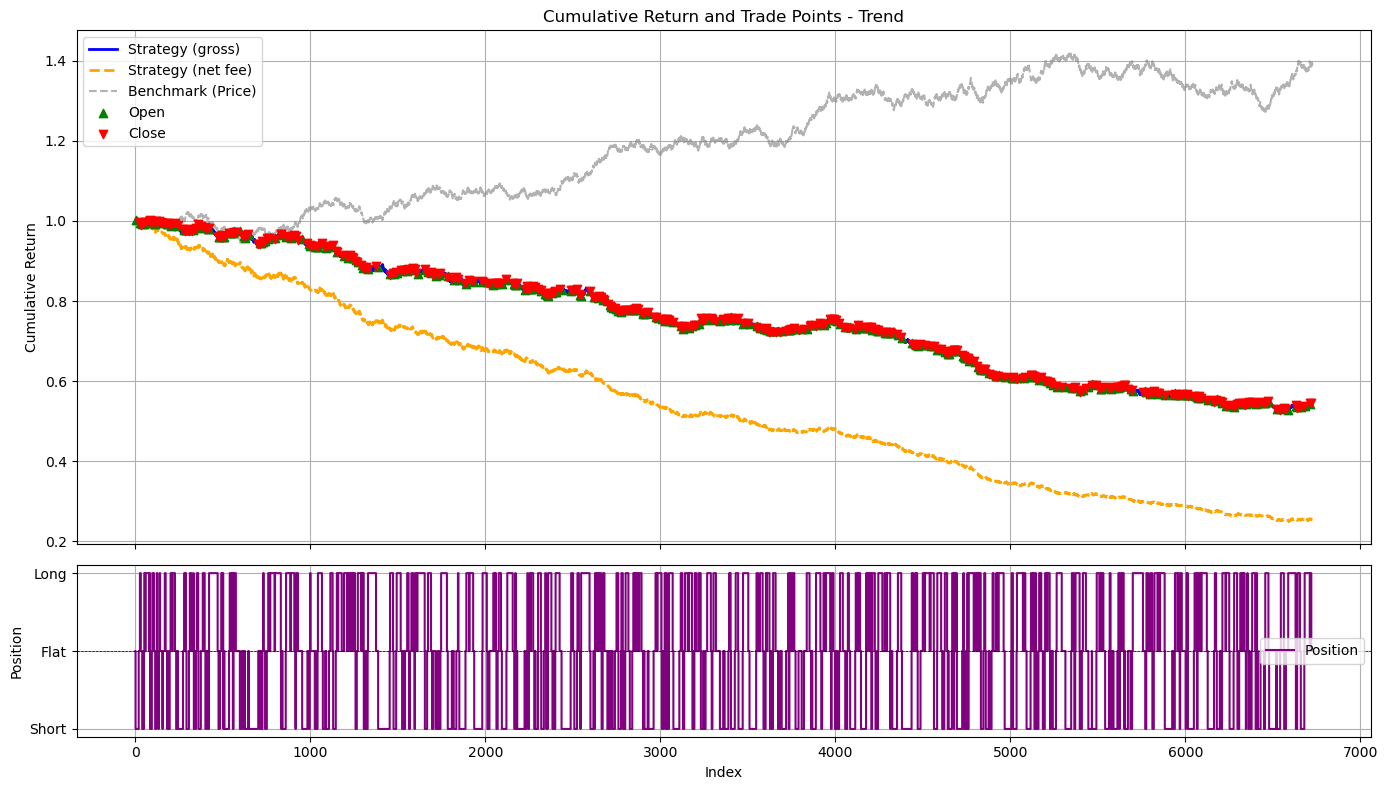


=== Strategy Summary (MEAN_REVERSION) | Rolling: True ===
Total Trades      : 378
Winning Rate      : 44.18%
Strategy Return   : 79.98%
Benchmark Return  : 39.26%
Max Drawdown      : -5.53% at index 3964
Long Trades       : 184
Short Trades      : 194


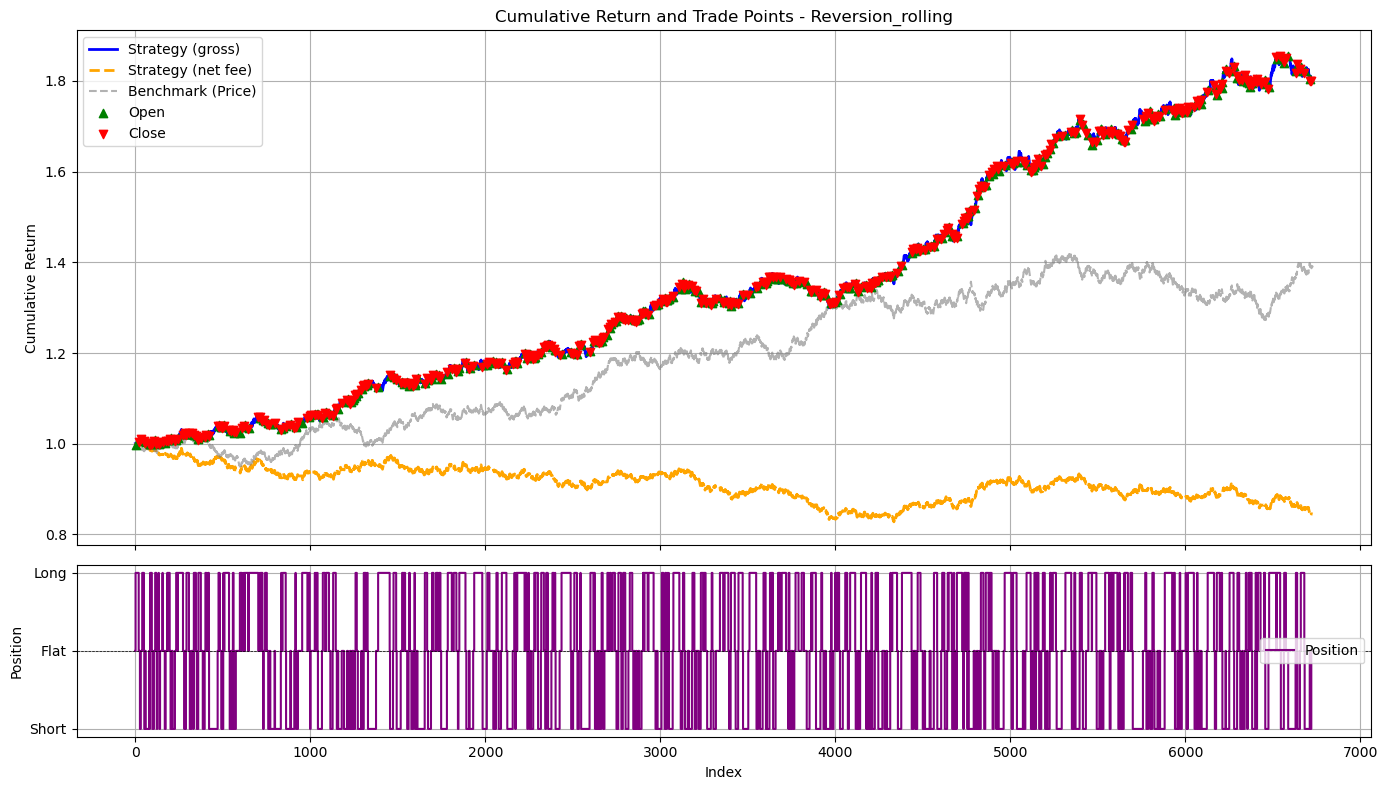

In [635]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_max_drawdown(cum_returns: pd.Series):
    roll_max = cum_returns.cummax()
    drawdown = (cum_returns - roll_max) / roll_max
    return drawdown.min(), drawdown.idxmin()

def strategy_with_position_logic(
    df: pd.DataFrame,
    price_col: str = "px",
    factor_col: str = "z_diff",
    upper_q: float = 0.9,
    lower_q: float = 0.1,
    mode: str = "trend",
    rolling_quantile: bool = False,
    window: int = 50
) -> pd.DataFrame:
    df = df.copy()

    if rolling_quantile:
        df["upper"] = df[factor_col].rolling(window=window, min_periods=1).quantile(upper_q)
        df["lower"] = df[factor_col].rolling(window=window, min_periods=1).quantile(lower_q)
        df["median"] = df[factor_col].rolling(window).quantile(0.5)  # 👈 加上这个！
        
    else:
        upper = df[factor_col].quantile(upper_q)
        lower = df[factor_col].quantile(lower_q)
        median_val = df[factor_col].quantile(0.5)

        df["upper"] = upper
        df["lower"] = lower
        df["median"] = median_val  # 👈 非 rolling 情况也要加


    if mode == "trend":
        df["signal"] = np.where(df[factor_col] > df["upper"], 1,
                         np.where(df[factor_col] < df["lower"], -1, 0))
    elif mode == "mean_reversion":
        df["signal"] = np.where(df[factor_col] > df["upper"], -1,
                         np.where(df[factor_col] < df["lower"], 1, 0))
    else:
        raise ValueError("mode must be 'trend' or 'mean_reversion'")

    # === 仓位逻辑 & 收益计算略，保持不变 ===
    # 以下部分和你原来的逻辑一致（略去重复部分）

    # 仓位计算
    position = [0]
    trades = []

    for i in range(1, len(df)):
        prev_pos = position[-1]
        signal = df.at[i, "signal"]
        factor_val = df.at[i, factor_col]
        median_val = df.at[i, "median"]

        if prev_pos == 0:
            position.append(signal)
            if signal != 0:
                trades.append((i, "open", signal))
        else:
            if mode == "trend":
                # trend: 穿越 median 则平仓
                if prev_pos == 1 and factor_val < median_val:
                    position.append(0)
                    trades.append((i, "close", prev_pos))
                elif prev_pos == -1 and factor_val > median_val:
                    position.append(0)
                    trades.append((i, "close", prev_pos))
                else:
                    position.append(prev_pos)
        
            elif mode == "mean_reversion":
                # meanrev: 远离 median 则平仓（回到中位时反而持仓）
                if prev_pos == 1 and factor_val > median_val:
                    position.append(0)
                    trades.append((i, "close", prev_pos))
                elif prev_pos == -1 and factor_val < median_val:
                    position.append(0)
                    trades.append((i, "close", prev_pos))
                else:
                    position.append(prev_pos)

    df["position"] = position
    df["returns"] = df[price_col].pct_change().fillna(0)
    df["strategy_returns"] = df["position"] * df["returns"]
    df["cum_strategy"] = (1 + df["strategy_returns"]).cumprod()
    df["cum_benchmark"] = (1 + df["returns"]).cumprod()

    # 胜率统计
    win = 0
    loss = 0
    trade_returns = []

    for i in range(1, len(trades)):
        if trades[i-1][1] == "open" and trades[i][1] == "close":
            entry_idx = trades[i-1][0]
            exit_idx = trades[i][0]
            direction = trades[i-1][2]
            r = (df.loc[exit_idx, price_col] / df.loc[entry_idx, price_col] - 1) * direction
            trade_returns.append(r)
            if r > 0:
                win += 1
            else:
                loss += 1

    win_rate = win / (win + loss) if (win + loss) > 0 else 0
        
    # 最大回撤
    mdd, mdd_idx = compute_max_drawdown(df["cum_strategy"])

    print(f"\n=== Strategy Summary ({mode.upper()}) | Rolling: {rolling_quantile} ===")
    print(f"Total Trades      : {win + loss}")
    print(f"Winning Rate      : {win_rate:.2%}")
    print(f"Strategy Return   : {df['cum_strategy'].iloc[-1] - 1:.2%}")
    print(f"Benchmark Return  : {df['cum_benchmark'].iloc[-1] - 1:.2%}")
    print(f"Max Drawdown      : {mdd:.2%} at index {mdd_idx}")
    print(f"Long Trades       : {sum([t[2] == 1 for t in trades if t[1] == 'open'])}")
    print(f"Short Trades      : {sum([t[2] == -1 for t in trades if t[1] == 'open'])}")

    df["trade_marker"] = ""
    for idx, action, direction in trades:
        df.at[idx, "trade_marker"] = "open" if action == "open" else "close"

    return df

def plot_strategy(df: pd.DataFrame, price_col="px", mode="trend", fee=0.001):
    df = df.copy()
    
    # 计算仓位变化绝对值（交易发生点）
    df["position_change"] = df["position"].diff().fillna(0).abs()
    
    # 扣手续费，手续费在有仓位变化时扣除（开仓和平仓都扣）
    df["strategy_returns_net"] = df["strategy_returns"] - df["position_change"] * fee
    
    # 计算净累计收益
    df["cum_strategy_net"] = (1 + df["strategy_returns_net"]).cumprod()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # 画原始策略累计收益和扣手续费后的累计收益
    ax1.plot(df["cum_strategy"], label="Strategy (gross)", linewidth=2, color="blue")
    ax1.plot(df["cum_strategy_net"], label="Strategy (net fee)", linewidth=2, color="orange", linestyle="--")
    
    ax1.plot(df["cum_benchmark"], label="Benchmark (Price)", linestyle="--", alpha=0.6, color="gray")

    # 开仓/平仓点
    open_idx = df.index[df["trade_marker"] == "open"]
    close_idx = df.index[df["trade_marker"] == "close"]
    ax1.scatter(open_idx, df["cum_strategy"].iloc[open_idx], color="green", marker="^", label="Open", zorder=5)
    ax1.scatter(close_idx, df["cum_strategy"].iloc[close_idx], color="red", marker="v", label="Close", zorder=5)

    ax1.set_title(f"Cumulative Return and Trade Points - {mode.capitalize()}")
    ax1.set_ylabel("Cumulative Return")
    ax1.grid(True)
    ax1.legend()

    # 仓位图
    ax2.plot(df["position"], color="purple", drawstyle='steps-post', label="Position")
    ax2.axhline(0, color="black", linestyle="--", linewidth=0.5)
    ax2.set_ylabel("Position")
    ax2.set_xlabel("Index")
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(["Short", "Flat", "Long"])
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()



# df_plot = mo_df.select(["px", "factor_mean"]).to_pandas()

# 趋势策略
trend_df_roll = strategy_with_position_logic(plot_df, mode="trend", rolling_quantile=True, window=20)
plot_strategy(trend_df_roll, mode="trend")

# # 回归策略
revert_df_roll = strategy_with_position_logic(plot_df, mode="mean_reversion", rolling_quantile=True, window=20)
plot_strategy(revert_df_roll, mode="reversion_rolling")
#origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.001_rolling200.csv")


每组的 target_col 平均值:
     bs_group  px_pct_rol_sum_200
0           1           -0.007226
1           2           -0.008061
2           3           -0.007484
3           4            0.001314
4           5           -0.003600
..        ...                 ...
495       496            0.020840
496       497            0.023256
497       498            0.025570
498       499            0.012805
499       500            0.014055

[500 rows x 2 columns]
Spearman相关系数: 0.9402, p值: 4.138e-235


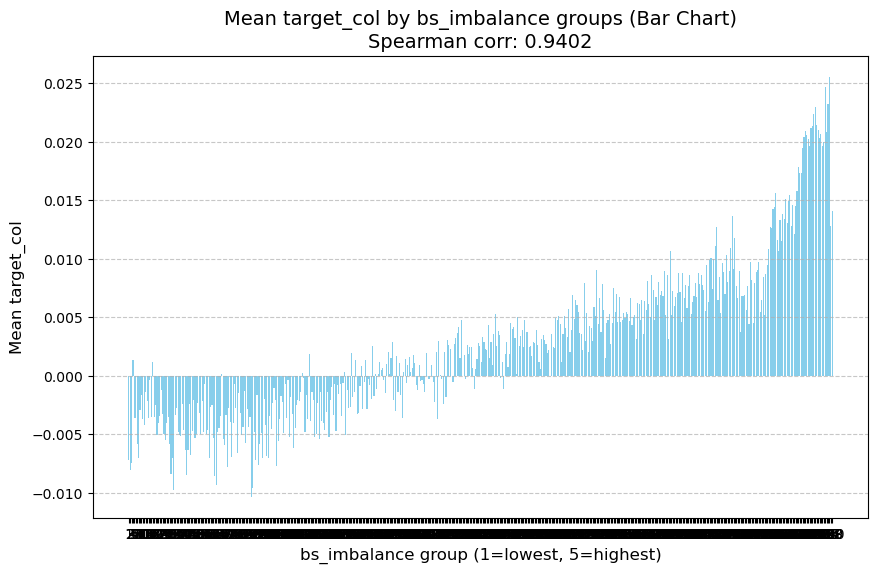

In [323]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# 假设你已经有了 DataFrame df，里面有 'bs_imbalance' 和 'target_col'
df = df.to_pandas()
df['bs_group'] = pd.qcut(df[f"bs_imba_rol_mean_{window}"], q=500, labels=False, duplicates='drop') + 1 # 组号1-5
# duplicates='drop' 是为了处理数据中可能存在大量重复值导致无法创建指定数量的箱子的情况

# 2. 每组计算 target_col 平均值
group_means = df.groupby('bs_group')[f"px_pct_rol_sum_{window}"].mean().reset_index()

print("每组的 target_col 平均值:")
print(group_means)

# 3. 计算单调相关性：Spearman相关系数，检验排序关系
# 注意：如果因为 duplicates='drop' 导致实际组数少于5，这里会是实际的组数
corr, pval = spearmanr(group_means['bs_group'], group_means[f"px_pct_rol_sum_{window}"])
print(f"Spearman相关系数: {corr:.4f}, p值: {pval:.4g}")

# 4. 画柱状图
plt.figure(figsize=(10, 6)) # 设置图的大小
plt.bar(group_means['bs_group'], group_means[f"px_pct_rol_sum_{window}"], color='skyblue') # 使用 bar 绘制柱状图
plt.title(f"Mean target_col by bs_imbalance groups (Bar Chart)\nSpearman corr: {corr:.4f}", fontsize=14)
plt.xlabel("bs_imbalance group (1=lowest, 5=highest)", fontsize=12)
plt.ylabel("Mean target_col", fontsize=12)
plt.xticks(group_means['bs_group']) # 确保 x 轴刻度显示为组号
plt.grid(axis='y', linestyle='--', alpha=0.7) # 只显示y轴网格
plt.show()
